# eBay Assistant v2 | Development Notebook

In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
load_dotenv()
import openai
import asyncio
import nest_asyncio
from PIL import Image as PILImage
from IPython.display import Markdown, display, Image, HTML

os.chdir(os.path.dirname(os.getcwd()))

In [2]:
from typing import List, Dict, Any
import uuid
from urllib.parse import urlparse
import base64
import lancedb
from marvin.beta.assistants import Assistant, Thread
from marvin.beta.assistants.formatting import pprint_messages, pprint_run

In [3]:
from src.utils import llm
from src.doc_store.ebay_scraper import eBayWebSearch, AverageSalePrice
from src.doc_store.ebay_utils import (
    process_ebay_images_with_async,
    deduplicate_products,
    deduplicate_search_items,
    download_and_save_images, 
    plot_images,
    eBayItems,
)
from src.utils.output import format_message

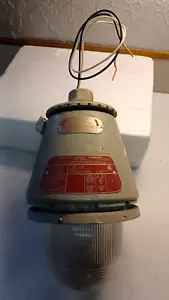

In [4]:
new_image = "test_image.jpg"
display(Image(filename=new_image))

In [5]:
def thumbnail(image, scale=3):
    return image.resize(np.array(image.size)//scale)

def safe_get(data, dot_chained_keys):
    """
    {'a': {'b': [{'c': 1}]}}
    safe_get(data, 'a.b.0.c') -> 1
    """
    keys = dot_chained_keys.split(".")
    for key in keys:
        try:
            if isinstance(data, list):
                data = data[int(key)]
            else:
                data = data[key]
        except (KeyError, TypeError, IndexError):
            return None
    return data


def response_parser(response: Dict[str, Any]):
    return safe_get(response, "choices.0.message.content")


def is_url(image_path: str) -> bool:
    """
    Check if the given string is a valid URL.

    Args:
        image_path (str): The string to check.

    Returns:
        bool: True if the string is a valid URL, False otherwise.
    """
    try:
        result = urlparse(image_path)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False
    
    
def encode_image_to_base64(image_path: str) -> str:
    """
    Encode a local image file to a base64 string.

    Args:
        image_path (str): The path to the image file.

    Returns:
        str: The base64 encoded string of the image.
    """
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


prompt_text_single_image = (
    "You are a highly knowledgeable eBay power seller. "
    "Your task is to examine the following image in detail. "
    "Begin with a descriptive title caption using level one markdown heading. "
    "Provide a comprehensive, factual, and price-focused explanation of what the image depicts. "
    "Highlight key elements and their significance, and present your analysis in clear, well-structured markdown format. "
    "If applicable, include any relevant facts to enhance the explanation. "
    "TITLE: "
)

prompt_text_multi_image = (
    "You are a highly knowledgeable eBay power seller. "
    "Your task is to examine the following set of images in detail, which are all of the same item. "
    "Begin with a descriptive title caption using level one markdown heading. "
    "Provide a comprehensive, factual, and price-focused explanation of what the image depicts. "
    "Highlight key elements and their significance, and present your analysis in clear, well-structured markdown format. "
    "If applicable, include any relevant facts to enhance the explanation. "
    "TITLE: "
)


def dynamic_prompt_selection(image_paths: List[str]) -> str:
    """
    Selects the appropriate prompt based on the number of images provided by the user.

    Args:
        image_paths (List[str]): A list of URLs or local paths for the images.

    Returns:
        str: The selected prompt text.
    """
    if len(image_paths) > 1:
        return prompt_text_multi_image
    else:
        return prompt_text_single_image


image_paths = ["test_image.jpg"]

prompt_text = dynamic_prompt_selection(image_paths)

additional_details = "The label says it's an explosion-proof light from Appleton Electric Company."

prompt_text += f"\n\nAdditional Context or Instructions Provided by the User:\n{additional_details}"

messages = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": prompt_text},
        ] + [
            {"type": "image_url", "image_url": {"url": path} if is_url(path) else f"data:image/jpeg;base64,{encode_image_to_base64(path)}"}
            for path in image_paths
        ],
    }
]

client = openai.OpenAI()

response = client.chat.completions.create(
    model="gpt-4-vision-preview", messages=messages
)

initial_inspection = response_parser(response.model_dump())
Markdown(initial_inspection)

# Vintage Appleton Electric Explosion-Proof Industrial Light

This image depicts a vintage industrial light fixture designed for use in hazardous environments where flammable gases or dust may be present. Specifically, this is an explosion-proof light by Appleton Electric Company, which specializes in electrical products for potentially explosive environments.

## Key Elements of the Fixture:

- **Housing:** The housing of the light fixture is made of a heavy-duty metal, likely aluminum or steel, which is designed to contain any sparks or flames that might occur due to electrical malfunction, preventing ignition of the surrounding atmosphere.
- **Label:** A red label on the housing provides information about the item. Even without clear visibility of the text in the image, such labels typically include details like the manufacturer, model number, certifications, and electrical specifications.
- **Globe:** Below the main housing, there is a clear glass globe which would enclose the bulb. This design is common for explosion-proof lights as it helps to prevent breakage and ensures the containment of sparks.
- **Mounting:** The top of the fixture has wiring extending out, indicating it is meant to be hard-wired into an electrical system and mounted to a surface or conduit system. It appears ready for installation, though the age and condition of the wiring should be inspected for safety.
- **Finish:** The fixture displays signs of wear, such as paint chipping, which is expected given its vintage nature. This can add to its authenticity and appeal as a collectible or for use in a retro industrial-themed setting.

## Significance and Price Considerations:

- **Collector's Item:** Vintage industrial equipment, especially from known brands like Appleton Electric, can be highly sought after by collectors or those looking for authentic period pieces for commercial, industrial, or personal settings.
- **Condition:** The condition of the light, including any wear, working status, and completeness would greatly affect its value. Fully functional, restored pieces tend to fetch higher prices.
- **Authenticity:** Original labels and manufacturer marks which indicate that the item is a genuine Appleton product contribute to its value.
- **Demand:** The market demand for vintage industrial equipment has been strong in recent years, with a trend towards repurposing such pieces for contemporary interior design, adding to its value.
- **Price Range:** Depending on the factors above, an item like this could range significantly in value. Comparable explosion-proof lights can sell anywhere from $50 to $300+ on platforms such as eBay, with particularly rare or well-preserved examples potentially commanding higher amounts.

### Enhancing the Listing:

To optimize the sale of this light on a platform like eBay, the seller should ensure to include:
- High-quality images from multiple angles.
- A thorough description of the condition, including any faults or missing components.
- Information about the manufacturer and model, if visible or known.
- Any history or provenance that accompanies the light.
- A note about the potential needs for rewiring or retrofitting for modern electrical standards.
- Shipping considerations due to the weight and fragility of the item.

Professional assessment or certification of the light's safety for actual use in hazardous environments, if intended for functional installation, would be essential. However, many buyers may be interested in it solely for its aesthetic and historical value.

In [6]:
import instructor
from pydantic import BaseModel, Field
from tenacity import Retrying, stop_after_attempt, wait_fixed

class eBayQueryList(BaseModel):
    """A eBay item that is being searched."""
    
    item_name: str = Field(
        ...,
        description="A concise, but descriptive name for the item of interest."
    )
    alternate_queries: List[str] = Field(
        default_factory=list,
        description="A diverse list of alternative eBay search queries that compliment the primary item of interest."
    )
    
def generate_base_queries(
    item_description: str, 
) -> eBayQueryList:
    client = instructor.patch(openai.OpenAI())
    return client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0.3,
        response_model=eBayQueryList,
        max_retries=Retrying(
            stop=stop_after_attempt(5),
            wait=wait_fixed(1),
        ),
        messages=[
            {
                "role": "system",
                "content": "You are a world class eBay assistant.",
            },
            {
                "role": "user",
                "content": f"The following is a detailed description of an item the user wants to buy on eBay. Take the description, and distill it down to concise, but descriptive name along with **2** diverse search queries for the item::\n\nITEM DESCRIPTION: {item_description}",
            },
        ],
    )
    

In [7]:
search_query_result = generate_base_queries(initial_inspection)
alternates = [query for query in search_query_result.alternate_queries]
search_tasks = [str(search_query_result.item_name)]
search_tasks.extend(alternates)
search_tasks

['Vintage Appleton Electric Explosion-Proof Industrial Light',
 'Appleton Electric explosion-proof light',
 'Vintage industrial hazardous environment light fixture']

In [8]:
averagePrice = AverageSalePrice(query=search_tasks[0], country='us', condition='all')
Markdown(str(averagePrice))

Item Description: Vintage Appleton Electric Explosion-Proof Industrial Light

Average Price (based on 59 sold items):

* Item: $71.73 ($20.0 to $200.0)

* Shipping: $19.27 ($6.0 to $43.21)

* Total: $91.0

In [9]:
sold_items = eBayWebSearch("Vintage Appleton Electric Explosion-Proof Light", alreadySold=True)
len(sold_items)

CPU times: total: 906 ms
Wall time: 4.63 s


61

In [11]:
Markdown(str(sold_items[1]))

**VTG Appleton Electric Industrial Submarine Uni Let Explosion Proof Wall Light**

Pre-Owned

Sold  Mar 6, 2024

$47.89

+$68.30 shipping



Item description from the seller:

VTG Appleton Electric Industrial Submarine Uni Let Explosion Proof Wall Light

- [Listing link](https://www.ebay.com/itm/335055499761?itmmeta=01HSZ9V639M0K64C7YEA0VM4NK&hash=item4e02dd31f1:g:Vy4AAOSwgDRkvC74&itmprp=enc%3AAQAJAAAA4EMaSnRF8DZ8IxUUlXIWvJhycCXrea9%2BaxlxG6yudSvxG%2BnMxTx9QA5ERRyqLargPzRXDfwambQeJmhVU0aiKjsKjAmJ6SZ%2BbMqvjFQKRdhg2sl4d0YDmbeIN%2FeCjHjvIQOda71Z2AOhGDZrqVr%2Bv9kMZARKr%2BAE85JQVuQIhJxixwi667aKHPjb03Phvt%2Bf%2FOk8nanpcYnjyBfU1bQYQt6ZCK2tJxvovcoAjLYmreGSjLxL6fD51XVoOcwUhGx7IAe1NqlVkn2UI1uQl9vGB%2FDYp6U0%2Bm9%2FItaexIA5TFu5%7Ctkp%3ABk9SR9rh7OnPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/Vy4AAOSwgDRkvC74/s-l225.webp)

- eBay item number: 335055499761
----------------------------------------------------------------------------------------------------

In [29]:
from typing import List
import asyncio
from concurrent.futures import ThreadPoolExecutor
from transformers import CLIPTokenizerFast, CLIPModel, CLIPProcessor


def search_image_vectors(image_path: str, df: pd.DataFrame, n: int = 5) -> List[eBayItems]:
    # unique_table_name = f"ebay_{uuid.uuid4().hex}"
    unique_table_name = "test_table"
    db = lancedb.connect("./.lancedb")
    table = db.create_table(unique_table_name, schema=eBayItems, mode='overwrite')
    table.add(df)
    query_image = PILImage.open(image_path)
    res = table.search(query_image) \
        .limit(n) \
        .to_pydantic(eBayItems)
    # db.drop_table(unique_table_name)
    return res


# from transformers import CLIPModel, CLIPProcessor, CLIPTokenizerFast

# MODEL_ID = "openai/clip-vit-base-patch32"

# tokenizer = CLIPTokenizerFast.from_pretrained(MODEL_ID)
# model = CLIPModel.from_pretrained(MODEL_ID)
# processor = CLIPProcessor.from_pretrained(MODEL_ID)

# def embed_func(query):
#     inputs = tokenizer([query], padding=True, return_tensors="pt")
#     text_features = model.get_text_features(**inputs)
#     return text_features.detach().numpy()[0]

# # Define the synchronous function
# def sync_embed_func(query):
#     inputs = tokenizer([query], padding=True, return_tensors="pt")
#     text_features = model.get_text_features(**inputs)
#     return text_features.detach().numpy()[0]

# # Create an asynchronous wrapper around the synchronous function
# async def async_embed_func(query):
#     loop = asyncio.get_running_loop()
#     with ThreadPoolExecutor() as pool:
#         result = await loop.run_in_executor(pool, sync_embed_func, query)
#     return result


# async def async_search_image_vectors(image_path: str, df: pd.DataFrame, n: int = 5) -> List[eBayItems]:
#     unique_table_name = "test_table"
#     db = await lancedb.connect_async("./.lancedb")
#     async_tbl = await db.create_table(
#         unique_table_name,
#         schema=eBayItems, 
#         mode='overwrite',
#     )
#     await async_tbl.add(df)
#     image_query = PILImage.open(image_path) 
#     query_vector = await async_embed_func(image_query)   
#     return await async_tbl.vector_search(query_vector=query_vector).limit(n).to_pydantic(eBayItems)

        
        
async def get_similar_listings(search_queries: List[str], image_path: str, n: int = 10, sold: bool=True):
    """
    Asynchronously searches for similar eBay listings based on given queries and an image path.
    Processes images asynchronously and deduplicates products to find the best matches.

    Args:
        search_queries (List[str]): A list of search queries.
        image_path (str): The path to the image for similarity search.
        n (int): Number of image results per search query after sorting by image similarity.

    Returns:
        List: A list of the best matching listings based on image similarity.
    """
    async def process_search_query(query):
        print(f"Searching for {query}...")
        search_results = eBayWebSearch(query, alreadySold=sold)
        await process_ebay_images_with_async(search_results)
        search_results = deduplicate_products(search_results)
        print(f"Analyzing descriptions and images from {len(search_results)} active listings...")
        df = pd.DataFrame([r.to_data_dict for r in search_results])
        best_images = search_image_vectors(image_path, df, n)
        return (search_results[:n], best_images)

    tasks = [process_search_query(query) for query in search_queries]
    results = await asyncio.gather(*tasks)

    return results

In [102]:
nest_asyncio.apply()

query = search_tasks[0]

all_results = []

async def main():
    search_queries = search_tasks
    image_path = "test_image.jpg"
    listings = await get_similar_listings(search_queries, image_path, n=20, sold=True)
    return listings

async def run_main_and_get_result():
    result = await main()
    all_results.extend(result)
    
asyncio.run(run_main_and_get_result())

Searching for Vintage Appleton Electric Explosion-Proof Industrial Light...
Searching for Appleton Electric explosion-proof light...
Searching for Vintage industrial hazardous environment light fixture...
Analyzing descriptions and images from 59 active listings...


100%|██████████| 59/59 [00:01<00:00, 33.62it/s]


Analyzing descriptions and images from 59 active listings...


100%|██████████| 59/59 [00:01<00:00, 33.60it/s]


Analyzing descriptions and images from 59 active listings...


100%|██████████| 59/59 [00:01<00:00, 32.49it/s]


In [103]:
from typing import List, Tuple

def print_search_results(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int):
    """
    Prints the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), None)
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    display(Markdown((f"Search for `{query}` returned {len(base_results)} results")))
    display(Markdown((f"Top results based on **{search_type}**:\n")))
    for result in results[:4]:
        display(thumbnail(result.image))
        display(Markdown((str(result))))
        
        
def construct_search_results_markdown(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int) -> str:
    """
    Constructs a Markdown string of the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).

    Returns:
        str: A Markdown formatted string of the search results.
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), "Unknown search type")
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    
    markdown_str = f"## Search for **{query}** returned {len(base_results)} results\n"
    markdown_str += f"### Top results based on {search_type}:\n"
    
    for result in results:
        markdown_str += f"{str(result)}\n\n"
    
    return markdown_str

In [106]:
image_results0 = construct_search_results_markdown(all_results, search_tasks, query_number=1, search_type_code=1)
results0 = construct_search_results_markdown(all_results, search_tasks, query_number=1, search_type_code=0)
results0 += "\n\n" + image_results0

Markdown(image_results0)

## Search for **Appleton Electric explosion-proof light** returned 20 results
### Top results based on Image Analysis:
**Appleton Used Met master Weatherproof Light Fixture Lap Explosion Proof Untested**

Parts Only

$49.98

+$43.99 shipping



Item description from the seller:

Appleton Mercmaster weatherproof lamp fixture. Heavy with aged patina Untested for repair or parts.
Industrial and explosion proof. Could not find model number. Sorry for high shipping but it weighs a
lot Make an offer

- [Listing link](https://www.ebay.com/itm/134873459995?itmmeta=01HSZF8VTCHQSSJBP0ZFJF46WZ&hash=item1f6715ad1b:g:eOcAAOSwYOVledAB&itmprp=enc%3AAQAJAAABALNiWfZxVCPmlbDhU17irYGn6ubVUSFurVMOBIQRFM2HXUuQYod%2FDf4Rh4GF%2F6Rj9YyAJZc1IvGCl3B0uk8IHrnqjjBFdCIDFsfQbVOJTv4SnB0k5sHYACKc1%2BEdjOF1N2GdSgwrOSxNZoc64jgbQ7fkMka5V52NSMRfxVkWyOZvS3HFu4J3PUIAx1SUGSdJ6%2FiUMZBRH1QMyc4FvZUuLCeK04BoqBmvHDSzd3hi%2Bs6a8Wr0OUERKLWhu2O95AQz6OPZWaa14meMZlrKnj%2FkWQZsvI5OmT3uQNfz0lOEk%2FPOiG%2B%2Fv3vp7A1DD5%2Fsw8FLDPIxHQ7XimpDfk7HCP4DM%2B8%3D%7Ctkp%3ABk9SR6S9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/eOcAAOSwYOVledAB/s-l225.webp)

- eBay item number: 134873459995
----------------------------------------------------------------------------------------------------

**Appleton Electric Company Unilet Form 100-200 Light W/ Glass Globe**

Pre-Owned

$29.95

+$12.08 shipping



Item description from the seller:

This is for an Appleton Electric Company Unilet Form 100-200 Light W/ Glass Globe. Untested. Globe
is approximately 6” tall by 3” at the threaded end. Cast base approximately 3.5” tall. Please see
pictures for full description and let me know if you have any questions or would like additional
pictures before bidding. Thank yo

- [Listing link](https://www.ebay.com/itm/156130804126?itmmeta=01HSZF8VTCRP6J2JNYZ5SRRPJ0&hash=item245a1f019e:g:TdEAAOSwatll8lBy&itmprp=enc%3AAQAJAAAA4I4c5TdlXCW%2BRs2ZUBtvNPcCxVCzy0hLowQF%2Bw1ygl%2BbIabYPKN2FZKzUW3nAAsvdKakt3NTm4smVwCPwgsVMSlDkMZAgNjMQMn4tRApkrt7lT9CJwVk5wvlWFgk6QMg4N0OIzRyZ7WP9CUz9hiSLHdD8u6kBV0jcJflmFFpMVUqQPKuSSlImB%2BKWVzeS1e%2Flej9zslUl1Jifg%2BPflYuzw0jqHF1SToSa7KutdB3RxmvYMANKET8ICJsa2p8hyRlYJStkdrKJA3ulZR05yH%2FOa5WsmXC4KgDkBQYM3n2iibL%7Ctkp%3ABk9SR6S9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/TdEAAOSwatll8lBy/s-l225.webp)

- eBay item number: 156130804126
----------------------------------------------------------------------------------------------------

**Vintage Appleton Electric Explosion Proof Light Fixture Form 100 With Red Globe**

Pre-Owned

$75.00

+$16.25 shipping



Item description from the seller:

Shipped FedEx / UPS Nice vintage industrial explosion proof light fixture with red globe. Ready to
be hardwired as shown in pictures. Shipping to lower 48 only In great condition See pictures Thank
you ðŸ˜

- [Listing link](https://www.ebay.com/itm/335199577310?epid=1769711780&itmmeta=01HSZF8VTBR86P3YZYK65C0SWB&hash=item4e0b73a4de:g:DtgAAOSw-5xlmwJt&itmprp=enc%3AAQAJAAAA4M%2BH92pW3%2F33RMx5Bi2ZzH43E5vfbMe4ON4WrgUIlpMsFsP9DV29mMHOrTdTpPjLHS3P6sGcmPBu4uhagYi7Y2OqSmcQpBlFqIMDXsz96aY6Z7zoD%2BkaAtcgXRCaUNXKVZsAVwv5kqkJgsrDg9IlB5IY%2BsA72LOJQZilnHMzFz9LIYDyk8nynavL7EbOYME%2FJkHg6h3pOp2cBMz9RrmGJ4tGfAW%2BpuC0MWsQF1veSPKn1ujnEx3WmrTMZYLyz6kxWBd2yzL%2FuVOdbHDJ166qZlGDCEy4XWBdCU%2BYII8onQcw%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/DtgAAOSw-5xlmwJt/s-l225.webp)

- eBay item number: 335199577310
----------------------------------------------------------------------------------------------------

**Appleton Electric Company A-51 GRF Explosion Proof Light	Fixture 300 V 200 W VTG**

Pre-Owned

$50.00

Free shipping



Item description from the seller:

Appleton Electric Company A-51 GRF Explosion Proof Light Fixture 300 V 200 W VTG Used working
condition. Removed from working service environment. Industrial surplus. Item pictured is the exact
item you will receive, unless multiple quantities available. Most items ship same day or next day of
payment received from North Carolina. UPS Next Day Air orders will ship same day if paid before
3:00PM ES

- [Listing link](https://www.ebay.com/itm/226020546592?itmmeta=01HSZF8VTBP7QMVCPF06GGQVZY&hash=item349fdfd820:g:2RsAAOSwR~5l3Or-&itmprp=enc%3AAQAJAAAA4G8zov0Ske2d8xMmiSOLzzN%2FgmrR3laqxLa6zwgBYXqjNh025bqT2i8gBLKvEsPhQJQ4cHOpkQEKNuqkBl6WimmJxzgVdCd%2FMMOafPWItgp%2F1Rf%2FowpQXfAuVNRdADcJxM4fno5sl35QEZ8uD9iI5jQr3eixCcjq9YifYFpJMepORG2sIfWx9yO%2FA%2B3zXwBspKWDgdaLbB%2BUyM20wCVG5fTAs%2FL0Z%2Fxz%2FDrS8xLc8LwuImLz02aZBY1fgActLB9KtY05yJsIdseA8pmZiZKpULxZlU1fwFkrUpbayiqWT8Xh%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/2RsAAOSwR~5l3Or-/s-l225.webp)

- eBay item number: 226020546592
----------------------------------------------------------------------------------------------------

**Appleton Electric Explosion Proof Switch Light Type SSA**

Pre-Owned

$49.99

+$13.25 shipping



Item description from the seller:

Appleton Electric Explosion Proof Switch. Sold as is untested. See pictures for condition however,
if multiples are listed pictures may not be exact. . Will combine shipping on multiple items if
possible. LOC B-3

- [Listing link](https://www.ebay.com/itm/166057568325?itmmeta=01HSZF8VTC97ZH5F3EJXFNA8VA&hash=item26a9cd6845:g:oW4AAOSwXhpkSwbh&itmprp=enc%3AAQAJAAAA4AoTkga4qGPeClAnq2NcwhyHozFU9wL9SY%2Fj%2BSpPv2tIVVsVRRwK%2B2M11kAc%2FRaU9ch%2Bnk0U7JXtW0nfVmNirZZYV21NES3fzlacLvGux6fnigRfbHNURNFqS5eiDEsUN72ObByHjxOMb6QpV3sOujnNTTqD5IyC1mSqUCFKvgBh0k866fI1avQsXQutovJPEZaSCTaZIz7ivdSyTs9J1oFAmoadAl1beXC8zAgI06IY%2FN2PIwzURGyuJEHBFNOkCxiXInWWMlRO95%2FfUkqGQHTAct3FMeq5dwvstmM9vJlE%7Ctkp%3ABk9SR6K9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/oW4AAOSwXhpkSwbh/s-l225.webp)

- eBay item number: 166057568325
----------------------------------------------------------------------------------------------------

**Appleton Electric Explosion Proof Switch Light**

Pre-Owned

$117.00

+$23.05 shipping



Item description from the seller:

Appleton Electric Explosion Proof Switch Light. USED. Please See Photos We honor our listings for
accuracy. Also we honor eBays 30 day buyer protection guarantee. Please check your 30 day eBay buyer
protection guarantee to learn about buyers rights and conditions under which we do accept returns.
Don't hesitate to contact our friendly customer service department! Thanks for browsing our store,we
appreciate it. All purchases go towards creating "Work Off The Battlefield" and other Veterans
Initiatives. R6-16d

- [Listing link](https://www.ebay.com/itm/204589046249?itmmeta=01HSZF8VTBMCQWP7J4EWPFFBFZ&hash=item2fa27519e9:g:VaIAAOSw9R1lhJ76&itmprp=enc%3AAQAJAAABALQXbBIkCc7tJSAGCOkgZmfuUYihmoQKvP%2FmG19iwnufN020ic%2FPP%2FClJQkj2wp2531bGXfIxUy42JG3BxobIIW1oCplc9TPO9UHB2bdIw6eBmFLldNalN9SziGQjHItaxYAURATPgOf2sVaPToJ7E6iznuoo90Zpq81lgwBNwjuu%2Bons2NW27K2AKB3Qiw97BVQ%2F9q1W%2FyvAaP4bTxw%2F7uSxu%2BarcTr3Pfn8alcth5xlaJ2l5CZHS5OmVsnRT6EVb5aP7%2FmFUkl7dOif%2FB3mJKvY7%2BWu6UbPN4Md665OTNMEsLLl5Ofirj0zRGhu4Tzse%2FaE2BdfwDlMZqT3I6Wlqg%3D%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/VaIAAOSw9R1lhJ76/s-l225.webp)

- eBay item number: 204589046249
----------------------------------------------------------------------------------------------------

**Appleton ENR5201 Explosion Proof Receptacle And Switch**

New – Open box

$219.00

Free shipping



Item description from the seller:

This Appleton ENR5201 Explosion Proof Receptacle And Switch is the perfect addition to your
electrical equipment collection. With its brand name Appleton, you can be sure of its quality and
durability. It is suitable for use in hazardous environments, making it ideal for industrial and
business needs. The item being sold is in new and unused condition, ready to be put to use. Its
unique features and aspects, such as the explosive proof nature, make it stand out from other
electrical outlets and receptacles. Add this to your cart and experience the benefits of this
explosion-proof receptacle and switch

- [Listing link](https://www.ebay.com/itm/305141404481?itmmeta=01HSZF8VTCAVBRF3BQ4SWMS199&hash=item470bd85341:g:psMAAOSwP4tlBPdR&itmprp=enc%3AAQAJAAABAI8tAqNLowjmYrJLu47q%2FgY4Uey%2BO9mtlyRrXHA6SiXa3Wt3UtWidneLfrqgTZp06m%2FZHngKC1mu7JeSMguhB2c0ZiJu%2FGg8vCrYd9pYLj5CzrQxTOEgprJK64TDm805L%2F4GuiltXcnDTaFE7Sseug6qOuOUPSKiBJ25T%2FR9ajjw7LY80ly4%2F20G1mWpvUFbHSd%2BNL3saNAwHNl%2B2gyDJe2ez6SaHdFXirQkz0eMa5DOMox8RLPRO%2Bh1FN6eMUeGdZwDJoWgtYjWyBvVS5i9e5wQuVIcnzm1Lo0AYpxjBzYKwnob74etl3LBu%2BluW8sI4N8PNNa9tYco7JjMC58sOYQ%3D%7Ctkp%3ABk9SR6a9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/psMAAOSwP4tlBPdR/s-l225.webp)

- eBay item number: 305141404481
----------------------------------------------------------------------------------------------------

**Appleton Electric Company A-51 64010	Explosion Proof Light Fixture 300 V 100 W**

Pre-Owned

$100.00

Free shipping



Item description from the seller:

Appleton Electric Company A-51 64010 Explosion Proof Light Fixture 300 V 100 W Used working
condition. Removed from working service environment. Industrial surplus. Item pictured is the exact
item you will receive, unless multiple quantities available. Most items ship same day or next day of
payment received from North Carolina. UPS Next Day Air orders will ship same day if paid before
3:00PM ES

- [Listing link](https://www.ebay.com/itm/326029361935?itmmeta=01HSZF8VTBMEX6RAKF0H3ZCE04&hash=item4be8dd430f:g:VOAAAOSwIvNl3PUw&itmprp=enc%3AAQAJAAAA4LDragc15dU5Fw9kVU5foQUJVQ0GBv1d2reaKJZ%2B9I%2B6pF%2BIegp13szvPVuAjp41oJde7%2FHASfSHkcNtKRSf26iYpjsmDLZdDQbaHeOE1KHHAeVheKACW9y5QhUb9WXT3AdBKbXEXeDgI26xm2jviJlInuqS9tR2W7LzoU7at9tXN3bTRQpDftQP55KU7Pv%2F1pcpDwjniSIHnHzUsQZ65ScjSYNvxyWswPFJErYKnqdDW0X5RbF7EpICmLEqsqlrlnMOPIA8cpyL5X8hNqcA28VCVUyYuEhm9Amh7x9ftMIP%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/VOAAAOSwIvNl3PUw/s-l225.webp)

- eBay item number: 326029361935
----------------------------------------------------------------------------------------------------

**Vintage Electric Industrial Explosion Proof Light Globe Fixture **

Pre-Owned

$12.99

+$13.60 shipping



Item description from the seller:

In good condition looks to have been painted

- [Listing link](https://www.ebay.com/itm/256390462712?itmmeta=01HSZF8VTD7PQ0K811EMHD6YJ4&hash=item3bb20ffcf8:g:0W0AAOSwaElloZiX&itmprp=enc%3AAQAJAAABAB2I5dPLc6cliZgnqcRx2zTOlsTN27wT96h9uPkUfhTHzGacAs5%2F9rFX0w8kJJhzGOo9kRn79HEBm%2FsrYxLl30vZv%2Fz2dg2xEt%2FxiO2U7wc%2BqyINMC2nw%2BXa1iuzT%2FN2Y4oJBF1T0vjYMDBf5TFbn203xatf2Kp5FMg4whfXfpgVSSOCXc8fOUKIWTLv08M7QVe0HZTUr7BpxLsz36eSP87SYTfU7ByMkfbi58%2FTLjou88IwmfsZdS3x2BsFWJnNdtHIVXR1%2BBcRMzgscfEt0CONelhvP3JiEbfgq3PJZKItcadbEqpVmGVojMm%2FLCS8Wd6iyweLDAJrRrvfY6tMsDM%3D%7Ctkp%3ABk9SR6i9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/0W0AAOSwaElloZiX/s-l225.webp)

- eBay item number: 256390462712
----------------------------------------------------------------------------------------------------

**Crouse Hinds explosion proof light**

Pre-Owned

$20.50

+$14.38 shipping



Item description from the seller:

This Crouse-Hinds explosion proof light is perfect for industrial lighting needs. It is designed to
withstand hazardous environments and provide safe illumination. With its durable construction and
high-quality design, this light is sure to last for many years to come. Ideal for use in facilities
requiring maintenance and safety, this light is suitable for various applications. Its brand,
Crouse-Hinds, is known for producing reliable and efficient lighting solutions. Get the job done
with confidence and add this explosion proof light to your facility lighting fixtures today. On
Feb-01-24 at 12:40:35 PST, seller added the following information: Original Crouse-Hinds explosion
proof light, working condition. Original bulb with the CH name on it. Small Crack in glass near
base. This Crouse-Hinds explosion proof light is perfect for industrial lighting needs. It is
designed to withstand hazardous environments and provide safe illumination. With its durable
construction and high-quality design, this light is sure to last for many years to come. Ideal for
use in facilities requiring maintenance and safety, this light is suitable for various applications.
Its brand, Crouse-Hinds, is known for producing reliable and efficient lighting solutions. Get the
job done with confidence and add this explosion proof light to your facility lighting fixtures today

- [Listing link](https://www.ebay.com/itm/296196894847?itmmeta=01HSZF8VTCJ9B5W07KZ105B5PM&hash=item44f6b5f07f:g:IHQAAOSwYe9lpfbk&itmprp=enc%3AAQAJAAABAPIm%2BSfQKvd0MKcA5SZ96SewgnCT6qDNds97w84KnerIwmsWnyMP5pG%2FHJkVJMBcXfWRs3poDZVNUTcF8u%2BDU8fxAUZZ7ggLAb%2Bt%2FgiBgrNqtFW6c3pw%2BrWVYcHVJpu%2FJHbonptV%2B4g9wkD1ipagyE2w9r30IaZTaWOsCVAoIHrzuiicMWvo60Gqp6x%2FxJVKL39REB5st%2BfblOGJGDl81KCFESXMmRvp0DAUVal%2FD3eTyLr%2B7gn8k1Q4ghZrKfnlQTN2EoFMKReFxkRHmxoNVDGv2mOF7P%2BhDumMQTQt0ydl%2B%2BuyEL1MROdtJvysUWbRm0CM9IM7WPjMkir5Id730l8%3D%7Ctkp%3ABk9SR6a9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/IHQAAOSwYe9lpfbk/s-l225.webp)

- eBay item number: 296196894847
----------------------------------------------------------------------------------------------------

**⭐NEW⭐ APPLETON EFS2524 EXPLOSION PROOF PILOT LIGHT 3/4"**

Brand New

$199.99

Free shipping



Item description from the seller:

NEW no factory packaging. In stock, on shelf,....and ready to ship! YOU ARE GETTING THE ONE IN THE
PICTURES. THANK YOU FOR LOOKING. Check out my other items ! USR1-S2-

- [Listing link](https://www.ebay.com/itm/145353643666?epid=21051858287&itmmeta=01HSZF8VTCF7E508QSBTQ2R0JM&hash=item21d7c09692:g:nR0AAOSwx5xlI3p8&itmprp=enc%3AAQAJAAAA4Ocjek0D4JfmF5hUyxxzMLNCtrrXX5XmW4mP1FAkOmQ1Nw65QCH3qTETq8wCoYH4OBCaRkFaty7sLP2zdv5bgKSmyKELCWUmljigr0Vxqgtd7lKzs7h8qWwkblGULnVhM4u0SBfcK8nox21j8CKmO9dXMvTv%2Fi1PUhbgsPGdP1imFyk67Kju5xw4bGWf7se3V9SQ9s8w8TLNmzzBVvqiHsAfhEBt1Sxktku4WyV1dVHAutMtIQbnT6OZv4Rb1JRyOy10YkFgsOQFZyprxhzLIeWu9wigqP4sSbakx4PiBWVL%7Ctkp%3ABk9SR6a9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/nR0AAOSwx5xlI3p8/s-l225.webp)

- eBay item number: 145353643666
----------------------------------------------------------------------------------------------------

**APPLETON EFDCB175-J1 EXPLOSION PROOF WITH LIGHT New In Box 3/4”**

Brand New

$129.99

Free shipping



Item description from the seller:

APPLETON EFDCB175-J1 EXPLOSION PROOF WITH LIGHT New In Box check my other items and feedbac

- [Listing link](https://www.ebay.com/itm/202161707650?epid=23012135627&itmmeta=01HSZF8VTCCF04ZC5NMX5JQ1W3&hash=item2f11c6da82:g:3YkAAOSwNw1ePDyv&itmprp=enc%3AAQAJAAAA4E0gXasZtf3wbXfTlNmbIyQyANjVHjMyWaSRbXCRW0DxskP3EFlvxY6iI4IECFZC47yBMyo9gT2ykcrAL52vZYbWdO6lH3txFFElPAGsCx2Jgt6FMY3wZEokX3ULNEJV%2BR0LptYSH4Zs%2BRdz5JLniDGgc8857WdLJV1kSulIq92MeHE9QxeDZ%2Ft74yGLN66QP01DxFLDU%2B7sk1zrHiRE3FqFeIn4Ut0pkFgzbeoPeR2SFvQ3f8LcLsCDfOTpR6XGG04uphZZuxPz079Zf2bg2SPg9dvbPo1wWmkmN4lg%2FN%2Bh%7Ctkp%3ABk9SR6a9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/3YkAAOSwNw1ePDyv/s-l225.webp)

- eBay item number: 202161707650
----------------------------------------------------------------------------------------------------

**Vintage Appleton Electric Explosion Proof Light Fixture Form 100 W/Clear Globe**

Pre-Owned

$27.00

+$26.75 shipping



Item description from the seller:

This vintage Appleton electric light fixture is an industrial gem. It features a clear globe and is
designed for use in hazardous locations. The unit is made in the United States and is perfect for
facility maintenance and safety. It comes with one unit in the package and is ideal for customers
looking for reliable lighting fixtures. The brand name Appleton is synonymous with quality and
durability, making this unit a valuable addition to any workspace. Or horse barn

- [Listing link](https://www.ebay.com/itm/166548517074?epid=1769711780&itmmeta=01HSZF8VTCYJM60Y2XHM50R6J8&hash=item26c710b0d2:g:Q5QAAOSwJ4Jlogp5&itmprp=enc%3AAQAJAAAA4FqUgfkGNrjm31aMuGed7aXuFFIDpeGJ03ef6mh%2FuVZBquu7o%2BWQOoCRzuudI4KNYTv7LV6HvTBq9dKakIxJysD2z3j6EDHEDE5ZCJlLtdkpShVS0vGdey8K8oaZSC1D2%2BMqaLfClFAYnRKiW1ooWQtxPLcEnotGjmc%2F4rIh1Bb68zd3gRsfNXmAWtyu3kFg%2BXLWUURJPl1fU9Zw%2Fs2963peVv%2BZQomWQEmQZ4OV9DntY0K2ZqApuEmi3ViG2Yxl%2F8Kmhdsrp5fBbAltcOxxlACH05Qu1KUXc7pDZ7aS%2FwXE%7Ctkp%3ABk9SR6K9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/Q5QAAOSwJ4Jlogp5/s-l225.webp)

- eBay item number: 166548517074
----------------------------------------------------------------------------------------------------

**Appleton form 200 red caged light explosion proof style amber **

Pre-Owned

$30.00

+$45.50 shipping



Item description from the seller:

UPSTATE BREAKER WHOLESALE “Anything Electric” Warehouse Location(s): Albion: Z1-I8-A Item Details
Appleton form 200 red caged light USED MAY HAVE SHELF WARE We try to be as descriptive as possible
for each item and represent each item in the pictures. Please check the payment instructions below
for the types of payments we accept. If you have to get a hold of us, look us up on the net Upstate
Breaker We test our items to the furthest extent that we can. PLEASE NOTE: This is for a quantity of
one. If we show two in the same picture it is for reference only! Upstate Breaker Wholesale provides
a 1 year warranty on this item. Warranty begins on date of purchase. Payment We accept PayPal and
Credit Card Payments through PayPal. All New York State customers are subject to New York State
Sales Tax. Please note that payment must be made within 7 days after the auction has ended. Shipping
We Ship Daily Shipping (Packaged Items) We combine all shipping! If shipping cost is higher than
expected, please contact us to request combined shipment! If flat shipping is available we will
combine as much as possible We will NOT package an item in a small flat rate box, if the item is
oversize and cannot be properly cushioned If you want to use your own UPS account please call us
first, or message us prior to making payment We can ship using other services but you must email us
your own label and schedule a pickup If you need overnight shipping and it's past 2:00 PM eastern
time, please call us to let us know you paid for overnight shipping so we can get it out. We ship up
to 4:30 PM for next day shipping. That does not include freight shipments! Freight Please include
all info when asking for cost on shipping, or it will slow the process down Do you have a forklift,
a loading dock or neither? Is is a business location or not? What is your zip code? What is your
company name if you have one and your name? What is your phone number and extension if you have one?
We have very reasonable rates Import duties, taxes, and charges are not included in the item price
or shipping cost. These charges are the buyer's responsibility. Please check with your country's
customs office to determine what these additional costs will be prior to bidding or buying. Warranty
Upstate Breaker Wholesale provides a 1 year warranty on this item. Warranty begins on date of
purchase. Please note that we are not an authorized dealer for any of the products we list on eBay.
Therefore we do not guarantee that the item featured in this listing will be covered by the
manufacturer's warranty or support Contact Us Have A Question? Click Here to contact us through the
eBay messaging system

- [Listing link](https://www.ebay.com/itm/352993105730?itmmeta=01HSZF8VTCAVB7MRYH1Q04T9T2&hash=item5230075742:g:G~gAAOSw1jJeYQSv&itmprp=enc%3AAQAJAAAA4AXs%2FzSpE8sLuEtJWxVHNgq4uPmKi2ukpoVmDsy1LloMewEqpCmHdTD6%2Bbj4fgeHaSS2%2Bi%2BxFTeyhih2f0irwF3%2BMULWhG5txjsrc07bqt93CJmxcZ53iYd4gfOH1GbSJau8JgGClqmRSNajo%2B%2F9zDFqpDppiH1O9rab8wnvuJZIWMVnhUjPyq5iAKMuI%2FR6MCnufV1pq7Dc%2BDxJaPe1pnCokm1PuzGqGFoSB%2Fdwc4qsxK%2BRqn4%2Beb5dHYW9ira%2FKFFUwk9wsH%2ByaWXugc9kg%2BmxJCWVviKSSC4Df4n3xcRd%7Ctkp%3ABk9SR6K9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/G~gAAOSw1jJeYQSv/s-l225.webp)

- eBay item number: 352993105730
----------------------------------------------------------------------------------------------------

**Vintage Appleton Explosion Proof Light Lamp Fixture Glass Industrial cast cage **

Pre-Owned

$125.00

+$14.95 shipping



Item description from the seller:

Vintage Appleton Explosion Proof Light Lamp Fixture Glass Industrial cast cage. 1950s industrial
light. Wall mount or ceiling mount. Large vintage Appleton form 200 caged explosion proof light.
Clear glass in excellent condition. I don't know if the bulb works. Cast aluminum cage, shade. Very
rustic decor, shabby chic, steampunk style. I have another one list in my shop if you want a
matching set. See photos for condition and sizes. Thanks for looking!! VISIT MY SHOP FOR MORE UNIQUE
ITEMS!! Have a wonderful day 😃

- [Listing link](https://www.ebay.com/itm/354576499713?itmmeta=01HSZF8VTBBF8QE5920PX6E67Z&hash=item528e680401:g:U6IAAOSwhm5j5ogQ&itmprp=enc%3AAQAJAAAA4NE5JiazMGMXyNUTXPBwnnlzGUUrKHYz3fTx3oy7i%2BGk26sWwP27EFkLqvYytkulFR5Hf5hqC4AURGnDzoxSmV5splrCh%2FcvFOiGthsRBgCfcsywsVfBRcpLrzdAch%2BDV04shMcWCUdCqRvH%2Bmeb13tDofbK95ovfGoLq5%2BuPA39hZiiHvnoaJPhJc3AZ%2BTfQnc%2Bg81rdIhv8sIi5wR9dgJyOflG5IZYGHzd4o8%2BUFTNFjoVoWhVSA6eGQWVGhrFf3ShqDzh1hThUOkAtyPDTl3dezj0cLR%2FI9dTvDP%2BGZ4v%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/U6IAAOSwhm5j5ogQ/s-l225.webp)

- eBay item number: 354576499713
----------------------------------------------------------------------------------------------------

**Appleton Electric Company G-EFJB-30 300V  Explosion Proof Flood Light GEFJB30**

Open Box

$399.99

Free shipping



Item description from the seller:

Item ID: 540111-50/C/01 Condition Note : Item is Brand New in Open Box or Missing Box, Money Back
Guaranteed, See Pictures for Cosmetic and additional Details. We offer UPS, Fed Ex, and USPS
Overnight Shipping on most Items, Items must be purchased by 1pm Pacific time, Please Email us if
you need this service, in most cases we can ship on your own UPS or Fed-ex Account. Terms of Sale
International buyers are responsible for any Broker Fees, Duty Fees, Custom Charges and Local Taxes.
Values will not be lowered on Custom Forms or marked as gifts. Some items we sell will not ship out
of the Continental United States. Make sure the particular listing states World Wide Shipping Or ask
before purchasing. Due to the variety of products sold by us and their broad range of applications,
those responsible for the procurement, installation, application and/or use of purchased equipment
must satisfy themselves that all components meet performance and safety requirements including but
not limited to: all applicable laws, regulations, codes and standards. Shipping Information All
items shipped to a destination in the Continental United States are usually shipped via UPS or USPS.
Items are typically shipped out within 1 Day of receiving payment (excludes Weekends and US
Holidays) Shipping Discounts will be given to multiple item sales, Please Email us for a quote prior
to purchase

- [Listing link](https://www.ebay.com/itm/285163298970?itmmeta=01HSZF8VTB234BXNZPP90N3TZ8&hash=item42650ea09a:g:KwgAAOSwB5Nj9QZX&itmprp=enc%3AAQAJAAABAD%2BxfqOrnEk7ZJA2KF%2FVJdPfBU6Z%2F4bi9lOVWVe7PpMqOlrlUXP44G4Pn8WsTDTFs9lENYLOvUCoq0lACvWM6YSNj31jMLQRE9lOlfKeQI3kmxWGULU4gBkcf%2BWXd3LasnF%2BoIQ7pMSWXx1HP6TUZMU3gVS5OUqecR%2FkiodtkrxJCM3cQ2cOc%2BioY00oiRUDrrHnAXOAnwajHIa%2BND9am0XBaqWbW%2BsG8h4yVGHB41VHJI%2FxKICeHx1s%2B0ihQrqH9MFiVL0FrwnCHHY%2BZsDzv1I8x89DDXyfvD8ZkK%2B%2Byh9vKKa%2FLQSOCg%2FPdTIOPyNEWi80pRIoP2uCNv4xS0nd7ko%3D%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/KwgAAOSwB5Nj9QZX/s-l225.webp)

- eBay item number: 285163298970
----------------------------------------------------------------------------------------------------

**Appleton Electric Form 100 Explosion Proof Industrial Light Caged Steampuck Lamp**

Pre-Owned

$99.99

+$23.00 shipping



Item description from the seller:

Appleton Electric Form 100 Explosion Proof Industrial Light Caged Steampuck Lamp

- [Listing link](https://www.ebay.com/itm/195726627928?itmmeta=01HSZF8VTBTQSVD1Y23QEF1XG4&hash=item2d92375458:g:TqcAAOSw9NhkRcv3&itmprp=enc%3AAQAJAAAA4NzByFPQyeQuXQ%2BpsNFtK%2FXV714PMqnONDnOMIljz5JF5N7jxYXWZbBx0foBxVn1XxaUnKr2qTPfatTJ7qq9BLFMlz05F4s07aiSQO5kEbgMG5cgxdjoQwi8twotzXrSu8WMswgvBh5YG7FRd%2FwM3E8pJyP3PzduNnn1f0N5R%2Ft%2BfAfff5F6im2v1MIjvwsc99%2BjxfPCZl3ySM72bAssMRk5%2FRNueOWTYt%2FErOpf%2B%2BugVtLDbpYWghIV6vW6dLpEC9aQPsl8%2FgBWzbzkoMrhkSaCQoUCKRYuvSqskHfUvdlO%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/TqcAAOSw9NhkRcv3/s-l225.webp)

- eBay item number: 195726627928
----------------------------------------------------------------------------------------------------

**Appleton Electric Form 100 Explosion Proof Industrial Light Caged Steampuck Lamp**

Pre-Owned

$39.99

Free shipping



Item description from the seller:

Introducing the Appleton Electric Form 100 Explosion Proof Industrial Light, a high-quality lighting
fixture perfect for industrial spaces. Made by trusted brand Appleton and manufactured in the United
States, this caged lamp is a great addition to any facility in need of reliable lighting. Ideal for
use in the Business & Industrial sector, and specifically in Facility Maintenance & Safety, Ships,
Boats, and residential, this industrial lighting fixture is sure to meet your needs. With its
explosion-proof design, it ensures maximum safety while providing ample light to your working area.
Don't miss the chance to add this top-of-the-line product to your inventory today

- [Listing link](https://www.ebay.com/itm/186313331349?itmmeta=01HSZF8VTBMSE4QQAT3NC821XG&hash=item2b6123d295:g:f7MAAOSwWo5lclb5&itmprp=enc%3AAQAJAAABAN5RVIFzxKG%2BkSOQf3e48DDPYVxPLCp75asyTVFwusRhnUMkawkhZcja7jo%2Fa6h%2FMf9HWVYv0H1kRen73EmAUoBfipcull5xAfuIj3E6Ham0Gkatdfh08WfKHCpYq6TCiKTAoyO9%2FuVeBB5KJDpq9IBom%2FFao7EA9Y3xEpgKB5WZs3ROEWrQ92EuMXvaP2jOoAc4exR5SQ4bdCDytPkYtRTsXpPcJ%2B6ta0HgMx%2Bo7n5GzoxCeYZnwRgsbW9XU6arcBh6Z2eSi82zNlXGOghUYf17HhJKaRNzdKtLEyJ6SLrnqXEBDLjE49BZRcEqfi%2FUVIs62m6XyvXZXrU5AZwOGpI%3D%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/f7MAAOSwWo5lclb5/s-l225.webp)

- eBay item number: 186313331349
----------------------------------------------------------------------------------------------------

**Vintage Appleton Electric Explosion Proof Light Desk/ Lamp Fixture Form 100**

Pre-Owned

$75.00

+$16.25 shipping



Item description from the seller:

Shipped FedEx / UPS Nice vintage industrial explosion proof light fixture made into a desk lamp as
shown in pictures. Could be attached to wall as well . Works Shipping to lower 48 only In great
condition See pictures Thank you ðŸ˜

- [Listing link](https://www.ebay.com/itm/335199568448?epid=1769711780&itmmeta=01HSZF8VTC4GEQ954XBJRRP401&hash=item4e0b738240:g:W7AAAOSwbGBlmwEX&itmprp=enc%3AAQAJAAAA4NSdEGTgRLx3GNzGkz9J53V3YID5nB6fjoaznASIMkmFFeOIw52gan4gKiIwaw6ZuoNMP%2FFKHFx9HLKTkwRUE7xhfDdQaYOeJ3XcQrDJ359JVbxkkFYv4SSShoOpoP9Mh7fom75zODgeSJ%2BROWzhxU2OKUnuvDSVLU0JdfyNe8XIxZ61VSb%2Fn0Cnd796YiM1qpcao%2BZaG%2FYOyAro4prOcDl%2Fs3N10HleUrs1K78b%2FgGo0T%2F31yQQx6mGUlWT2VEukoPPpgZLj4M454CwsVlG2uRG%2BBpWufFQO0oFyVZBttfD%7Ctkp%3ABk9SR6K9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/W7AAAOSwbGBlmwEX/s-l225.webp)

- eBay item number: 335199568448
----------------------------------------------------------------------------------------------------

**APPLETON EXPLOSION PROOF SWITCH EFS175-F2 (NOS)**

Brand New

$98.00

Free shipping



Item description from the seller:

APPLETON EXPLOSION PROOF SWITCH EFS175-F2 (NOS) G-

- [Listing link](https://www.ebay.com/itm/166542628737?epid=6056693342&itmmeta=01HSZF8VTDVMGEC2BJFCZGEY5B&hash=item26c6b6d781:g:LnIAAOSwgotlnTET&itmprp=enc%3AAQAJAAAA4OHbyhrSgyZSTjezbkCCL0D0YaQqTFjGHTDK2fCwKR1rUs%2F6Aik02MmeF1J24ThW1bDY82XSru46bhcH4HSUe5yhTfxTC0GR92A2FSrQxFbH23s2WZHnX733rFHcZbMGWiu0NirsWpsv7qvuyAt0vyBKcLLe2jPHSVgUfVa118a3pa6wVEMN9J3aP4hUhJWU3XwUao6zezM2aNwSxCP5ZDT2ddc36kkLSts19%2ByeQbcXoGZFcatQK8bg3jvSL64N5IybfbpB4onP0A%2B4AG%2BQxtdMEO%2FI%2BVuSSMiz2JqPZAD6%7Ctkp%3ABk9SR6i9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/LnIAAOSwgotlnTET/s-l225.webp)

- eBay item number: 166542628737
----------------------------------------------------------------------------------------------------



In [107]:
print(all_results[0][1][0])

**Vintage Appleton Electric Explosion Proof Light Fixture Form 100 With Red Globe**

Pre-Owned

$75.00

+$16.25 shipping



Item description from the seller:

Shipped FedEx / UPS Nice vintage industrial explosion proof light fixture with red globe. Ready to
be hardwired as shown in pictures. Shipping to lower 48 only In great condition See pictures Thank
you ðŸ˜

- [Listing link](https://www.ebay.com/itm/335199577310?epid=1769711780&itmmeta=01HSZBHHZH7W8MN5X3R9N78BZF&hash=item4e0b73a4de:g:DtgAAOSw-5xlmwJt&itmprp=enc%3AAQAJAAAA8M%2BH92pW3%2F33RMx5Bi2ZzH43E5vfbMe4ON4WrgUIlpMsFsP9DV29mMHOrTdTpPjLHSxRP8TYe8P7pTlXPFh4UQ1%2Blp3uhjwlQvkBUsGMINjzi5NK45aCqa3oCX142URegj1YofDw%2B43ReOcYqid8FgvwX%2B7y74iJ2hBXrVTSbS9m4G3UTRmt%2FGYoRaFEQDXxvTfGb5mWslvVqzLsqDMod%2F1zku48ATl9SliRjR7lZI5fIT%2FU2eSm179dW%2BnNll3o1fBlJTfFkAwnMmOS8ulJcfAsmgLz9rVpLWb7%2F1%2BbVTpR9w1mlKQJg275xU6e4stblg%3D%3D%7Ctkp%3ABk9SR-6fxuvPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/DtgAAOSw-5xlmwJt/s-l225.webp)

- eBay i

In [108]:
from typing import Callable
from langchain_openai import ChatOpenAI

from src.search.threadpool import run_functions_tuples_in_parallel
from src.utils import llm


USEFUL_PAT = "Yes useful"
NONUSEFUL_PAT = "Not useful"

image_comp_prompt = """
I'm planning to list the item in the first image on eBay and looking for good 'comps' to help determine the price. 
Please review and asses whether the second image is similar enough to be USEFUL. Respond with EXACTLY AND ONLY: "Yes useful" or "Not useful"
"""

def llm_eval_chunk(target_image: str, comp_image: str) -> bool:  

    def _extract_usefulness(model_output: str) -> bool:
        """Default 'useful' if the LLM doesn't match pattern exactly.
        This is because it's better to trust the (re)ranking if LLM fails"""
        if model_output.strip().strip('"').lower() == NONUSEFUL_PAT.lower():
            return False
        return True

    model_output = llm.prompt_multi_image_input(
        prompt=image_comp_prompt,
        image_paths=[
            target_image,
            comp_image,
        ]
    )

    return _extract_usefulness(model_output)


def llm_batch_eval_chunks(
    target_image: str, comp_images: list[str], use_threads: bool = True
) -> list[bool]:
    if use_threads:
        functions_with_args: list[tuple[Callable, tuple]] = [
            (llm_eval_chunk, (target_image, comp_image)) for comp_image in comp_images
        ]

        print(
            "Running LLM usefulness eval in parallel (following logging may be out of order)"
        )
        parallel_results = run_functions_tuples_in_parallel(
            functions_with_args, allow_failures=True
        )

        # In case of failure/timeout, don't throw out the chunk
        return [True if item is None else item for item in parallel_results]

    else:
        return [
            llm_eval_chunk(target_image, comp_image) for comp_image in comp_images
        ]

In [109]:
from src.doc_store.ebay_scraper import eBayProduct
from src.search.models import dataframe_to_text_nodes

def filter_chunks(
    target_image: str,
    chunks_to_filter: list[eBayItems | eBayProduct],
    max_llm_filter_chunks: int = 20,
) -> list[eBayItems | eBayProduct]:
    """Filters chunks based on whether the LLM thought they were relevant to the query.

    """
    if isinstance(chunks_to_filter[0], eBayItems):
        chunks_to_filter = chunks_to_filter[: max_llm_filter_chunks]
        llm_chunk_selection = llm_batch_eval_chunks(
            target_image=target_image,
            comp_images=[chunk.image_url for chunk in chunks_to_filter],
        )
        return [
            chunk
            for ind, chunk in enumerate(chunks_to_filter)
            if llm_chunk_selection[ind]
        ]
    else:
        chunks_to_filter = chunks_to_filter[: max_llm_filter_chunks]
        llm_chunk_selection = llm_batch_eval_chunks(
            target_image=target_image,
            comp_images=[str(chunk.item.image_url) for chunk in chunks_to_filter],
        )
        return [
            chunk
            for ind, chunk in enumerate(chunks_to_filter)
            if llm_chunk_selection[ind]
        ]

In [112]:
images_to_compare = all_results[1][1]
images_to_compare[0]

eBayItems(id='134873459995', text='eBay\nAppleton Mercmaster weatherproof lamp fixture. Heavy with aged patina\nUntested for repair or parts.\nIndustrial and explosion proof.\nCould not find model number.\nSorry for high shipping but it weighs a lot\nMake an offer-', vector=FixedSizeList(dim=512), image_uri='data\\multimodal\\Appleton_Used_Met_master_Weatherproof_Light_Fixture_Lap_Explosion_Proof_Untested.jpg', title='Appleton Used Met master Weatherproof Light Fixture Lap Explosion Proof Untested', price='$49.98', image_base64='UklGRhARAABXRUJQVlA4IAQRAABQZACdASqpAOEAPm0wlEekIqInJjGMQOANiWdr213KO1va4h80m7352HdRfWo6MusFm1v896C7fun9spysHpvoA9YrwRaiXTDLnh5dSSDc6Z2F40KpPRdFgwa2SqOvM/oiz3TBbemKpPqPUxZwAuXVKYzFd09ScCQz2Qj+vxzMOydL+Qe0S/piVyFMb5rngAQPczM2Ctmt6tnvdCsw0xhHOMw2FwREv8DnaAvQLKtNd4yzkCIwXfquVj8N8JtAtYa654xfKp1Z8zXPaNOQVEvyvbCLbWjVJ80PiR0bbqgxOq8aDZok7fs7BzlqnZjYdqgjOw0zuZQOw4T+NoOv0A6teRWLDJylr2HcWFxQ9aSL4zLr4GakWIC1Al1vEEG4LvCVVTZFD66A9nzr2vgI8vHINYTuZYUppZRU9VaWedVUJoin3GJKXDP9G

In [113]:
filtered_chunks = filter_chunks(new_image, images_to_compare)
display(Markdown((f"\nReturned {len(filtered_chunks)} best matching images from {len(images_to_compare)} candidates\n\n")))
display(Markdown(f"### {query}"))
for obj in filtered_chunks:
    display(Markdown(str(obj)))
    display(Markdown("_"))

Running LLM usefulness eval in parallel (following logging may be out of order)



Returned 2 best matching images from 20 candidates



### Vintage Appleton Electric Explosion-Proof Industrial Light

**Appleton Electric Company A-51 GRF Explosion Proof Light	Fixture 300 V 200 W VTG**

Pre-Owned

$50.00

Free shipping



Item description from the seller:

Appleton Electric Company A-51 GRF Explosion Proof Light Fixture 300 V 200 W VTG Used working
condition. Removed from working service environment. Industrial surplus. Item pictured is the exact
item you will receive, unless multiple quantities available. Most items ship same day or next day of
payment received from North Carolina. UPS Next Day Air orders will ship same day if paid before
3:00PM ES

- [Listing link](https://www.ebay.com/itm/226020546592?itmmeta=01HSZF8VTBP7QMVCPF06GGQVZY&hash=item349fdfd820:g:2RsAAOSwR~5l3Or-&itmprp=enc%3AAQAJAAAA4G8zov0Ske2d8xMmiSOLzzN%2FgmrR3laqxLa6zwgBYXqjNh025bqT2i8gBLKvEsPhQJQ4cHOpkQEKNuqkBl6WimmJxzgVdCd%2FMMOafPWItgp%2F1Rf%2FowpQXfAuVNRdADcJxM4fno5sl35QEZ8uD9iI5jQr3eixCcjq9YifYFpJMepORG2sIfWx9yO%2FA%2B3zXwBspKWDgdaLbB%2BUyM20wCVG5fTAs%2FL0Z%2Fxz%2FDrS8xLc8LwuImLz02aZBY1fgActLB9KtY05yJsIdseA8pmZiZKpULxZlU1fwFkrUpbayiqWT8Xh%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/2RsAAOSwR~5l3Or-/s-l225.webp)

- eBay item number: 226020546592
----------------------------------------------------------------------------------------------------

_

**Appleton Electric Company A-51 64010	Explosion Proof Light Fixture 300 V 100 W**

Pre-Owned

$100.00

Free shipping



Item description from the seller:

Appleton Electric Company A-51 64010 Explosion Proof Light Fixture 300 V 100 W Used working
condition. Removed from working service environment. Industrial surplus. Item pictured is the exact
item you will receive, unless multiple quantities available. Most items ship same day or next day of
payment received from North Carolina. UPS Next Day Air orders will ship same day if paid before
3:00PM ES

- [Listing link](https://www.ebay.com/itm/326029361935?itmmeta=01HSZF8VTBMEX6RAKF0H3ZCE04&hash=item4be8dd430f:g:VOAAAOSwIvNl3PUw&itmprp=enc%3AAQAJAAAA4LDragc15dU5Fw9kVU5foQUJVQ0GBv1d2reaKJZ%2B9I%2B6pF%2BIegp13szvPVuAjp41oJde7%2FHASfSHkcNtKRSf26iYpjsmDLZdDQbaHeOE1KHHAeVheKACW9y5QhUb9WXT3AdBKbXEXeDgI26xm2jviJlInuqS9tR2W7LzoU7at9tXN3bTRQpDftQP55KU7Pv%2F1pcpDwjniSIHnHzUsQZ65ScjSYNvxyWswPFJErYKnqdDW0X5RbF7EpICmLEqsqlrlnMOPIA8cpyL5X8hNqcA28VCVUyYuEhm9Amh7x9ftMIP%7Ctkp%3ABk9SR6C9o-_PYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/VOAAAOSwIvNl3PUw/s-l225.webp)

- eBay item number: 326029361935
----------------------------------------------------------------------------------------------------

_

In [101]:
images_to_compare = all_results[0][1]

filtered_chunks = filter_chunks(new_image, images_to_compare)
display(Markdown((f"\nReturned {len(filtered_chunks)} best matching images from {len(images_to_compare)} candidates\n\n")))
display(Markdown(f"### {query}"))
for obj in filtered_chunks:
    display(Markdown(str(obj)))
    display(Markdown("_"))

Running LLM usefulness eval in parallel (following logging may be out of order)



Returned 2 best matching images from 20 candidates



### Vintage Appleton Electric Explosion-Proof Industrial Light

**Appleton Electric Company A-51 64010	Explosion Proof Light Fixture 300 V 100 W**

Pre-Owned

$100.00

Free shipping



Item description from the seller:

Appleton Electric Company A-51 64010 Explosion Proof Light Fixture 300 V 100 W Used working
condition. Removed from working service environment. Industrial surplus. Item pictured is the exact
item you will receive, unless multiple quantities available. Most items ship same day or next day of
payment received from North Carolina. UPS Next Day Air orders will ship same day if paid before
3:00PM ES

- [Listing link](https://www.ebay.com/itm/326029361935?itmmeta=01HSZBHHZH5XDPKQYAWKEJ805T&hash=item4be8dd430f:g:VOAAAOSwIvNl3PUw&itmprp=enc%3AAQAJAAAA8LDragc15dU5Fw9kVU5foQUJVQ0GBv1d2reaKJZ%2B9I%2B6pF%2BIegp13szvPVuAjp41oAzXlSokAuUvUuJDleGpgVpac36%2FQFijhCQDBYgsyhdVFZFLQ2EaLl2zpvuLJ%2BABAY%2FlskTViTNRXyO%2BlaHQAJF%2FOMoxJF5Ap7KmKDZEoBBeBF306Wwz89vj0xZe%2BrMV7sDAAupwmVh1JF3kOwYHE%2BNmk3hLI2Xg%2FPZMEmelZwseONNghLp0b9kITdxVEaR8cXWY8Sa6tPGU2xCf9rFwmJKPWbel6dP7EY9XwEzKv4UOEUufU%2F%2BzEIAaSO3eZRLeCw%3D%3D%7Ctkp%3ABk9SR-6fxuvPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/VOAAAOSwIvNl3PUw/s-l225.webp)

- eBay item number: 326029361935
----------------------------------------------------------------------------------------------------

_

**Vintage Killark Industrial Explosion Proof Light Fixture EL I 200 Steampunk**

Pre-Owned

$79.00

+$27.65 shipping



Item description from the seller:

Vintage Killark Industrial Explosion Proof Light Fixture EL I 200  Hazard Light Fixture As-Is. Fair
to good cosmetic condition, showing signs of age, use, and wear. Believed to have been painted over
Aluminum vase. Great vintage patina, perfect for any industrial/steam punk setting or commercial
applications. Wiring cut but intact. Untested and sold as-is. Approximately 16 inches long x 10
inches diameter. Please indicate your choice of fixture - right or left piece in photo. Please
examine photographs for additional details and information. Ships via USPS Groun

- [Listing link](https://www.ebay.com/itm/314971628333?itmmeta=01HSZBHHZKE7K4Q8DV4FGPWEZY&hash=item4955c5a32d:g:JZwAAOSwbmllWQz7&itmprp=enc%3AAQAJAAAA8MIIr8NqdgiS8wOxWZJPkcXN8RqWYqyvtF2YLVgjn35fenN6zc9EzuZ3D1sTVJ%2FjsbBaGImOYYpP1UE%2B92Q9RIfnw3%2FytFnvBrYBfIewgoByXivwP5NBL22wcU9Fr5VWPLyjmNDNeBjyqzUZlrSpAOt%2Fjk9S4Eo6gxVX%2BeWeKOiFuY5EdoO61UwRwPlCV3UY48zLg2W68EaIGEfNZyUxvQnM1zd9Cl8F%2FCzOkFDLynyDwvSbWern9A35MJULAk8V%2FV7DcmmhrgFdeYvr8sTrHNXzxyXQogq0pu9oVgwHLriaDskQkBUVuIQN2Z1omtULQg%3D%3D%7Ctkp%3ABk9SR_SfxuvPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/JZwAAOSwbmllWQz7/s-l225.webp)

- eBay item number: 314971628333
----------------------------------------------------------------------------------------------------

_

In [29]:
def get_pricing_stats(item: str) -> str:
    """Fetch the average selling price for a given item"""
    return str(AverageSalePrice(query=item, country='us', condition='all'))

search_list = ", ".join(
    search_tasks
)
ai = Assistant(
    instructions="You are a helpful product research assistant, skilled at drafting engaging reports that are well structured, nicely formatted, and compelling to read.",
    tools=[get_pricing_stats],
)
thread = Thread(
)
thread.add(
    f"Please fetch pricing stats on each of the following items, and use the results to write a summary report in markdown.\n\nITEMS: {str(search_list)}"
)
run = thread.run(ai)

In [30]:
avg_pricing_message = thread.get_messages()
avg_pricing_message_str = format_message(avg_pricing_message[-1])
Markdown(avg_pricing_message_str)

# Summary Report on Explosion-Proof Lights Pricing Statistics

## Appleton Electric Explosion-Proof Light

- **Average Price** (based on 58 sold items):
  - **Item Price**: $70.44 (range: $14.99 to $219.00)
  - **Shipping**: $9.88 (range: $0.00 to $35.99)
  - **Total Price Including Shipping**: $80.32

## Industrial-grade Explosion-Proof Light

- **Average Price** (based on 55 sold items):
  - **Item Price**: $56.22 (range: $14.99 to $129.00)
  - **Shipping**: $8.78 (range: $0.00 to $26.75)
  - **Total Price Including Shipping**: $65.00

## Vintage Industrial Explosion-Proof Light

- **Average Price** (based on 58 sold items):
  - **Item Price**: $59.86 (range: $9.99 to $200.00)
  - **Shipping**: $16.67 (range: $6.16 to $35.00)
  - **Total Price Including Shipping**: $76.53

### Analysis

The **Appleton Electric Explosion-Proof Light** is the most expensive on average, both in terms of item price and total cost, including shipping. This could indicate higher quality, brand recognition, or specific features that appeal to buyers in this market.

The **Industrial-grade Explosion-Proof Light** offers the lowest average price, which suggests it could be the most cost-effective option for buyers looking for functional, yet budget-friendly explosion-proof lighting solutions.

The **Vintage Industrial Explosion-Proof Light**, while being in the middle range for its item price, carries a significantly higher shipping cost on average, which could be due to its vintage nature potentially requiring special handling or packaging.

### Conclusion

Potential buyers should consider the Appleton Electric model for a possibly higher-end product, the industrial-grade model for a budget-conscious purchase, and the vintage option if they are seeking a blend of functionality with a retro aesthetic, keeping in mind the higher shipping costs.

In [32]:
import asyncio
from typing import List

async def get_similar_listings(search_queries: List[str], image_path: str, n: int = 5):
    """
    Asynchronously searches for similar eBay listings based on given queries and an image path.
    Processes images asynchronously and deduplicates products to find the best matches.

    Args:
        search_queries (List[str]): A list of search queries.
        image_path (str): The path to the image for similarity search.
        n (int): Number of image results per search query after sorting by image similarity.

    Returns:
        List: A list of the best matching listings based on image similarity.
    """
    async def process_search_query(query):
        print(f"Searching for {query}...")
        search_results = eBayWebSearch(query)
        await process_ebay_images_with_async(search_results)
        search_results = deduplicate_products(search_results)
        print(f"Analyzing descriptions and images from {len(search_results)} active listings...")
        df = pd.DataFrame([r.to_data_dict for r in search_results])
        best_images = search_image_vectors(image_path, df, n)
        return (search_results, best_images)

    tasks = [process_search_query(query) for query in search_queries]
    results = await asyncio.gather(*tasks)

    return results

In [33]:
nest_asyncio.apply()

all_results = []

async def main():
    search_queries = search_tasks
    image_path = "test_image.jpg"
    listings = await get_similar_listings(search_queries, image_path)
    return listings

async def run_main_and_get_result():
    result = await main()
    all_results.extend(result)
    
asyncio.run(run_main_and_get_result())

Searching for Appleton Electric Explosion-Proof Light...
Searching for Industrial-grade explosion-proof light...
Searching for Vintage industrial explosion-proof light...
Analyzing descriptions and images from 55 active listings...


100%|██████████| 55/55 [00:01<00:00, 30.94it/s]


Analyzing descriptions and images from 119 active listings...


100%|██████████| 55/55 [00:01<00:00, 34.77it/s]


Analyzing descriptions and images from 118 active listings...


100%|██████████| 54/54 [00:01<00:00, 35.29it/s]


In [34]:
from typing import List, Tuple

def print_search_results(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int):
    """
    Prints the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), None)
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    display(Markdown((f"Search for `{query}` returned {len(base_results)} results")))
    display(Markdown((f"Top results based on **{search_type}**:\n")))
    for result in results[:4]:
        display(thumbnail(result.image))
        display(Markdown((str(result))))
        
        
def construct_search_results_markdown(
    all_results: List[Tuple[List, List]], 
    search_query_list: List[str], 
    query_number: int, 
    search_type_code: int) -> str:
    """
    Constructs a Markdown string of the search results for a given query number and search type code.

    Args:
        all_results (List[Tuple[List, List]]): A list of tuples, where each tuple contains two lists of search results.
        search_query_list (List[str]): A list of search queries.
        query_number (int): The index of the query in the search_query_list.
        search_type_code (int): The code indicating the type of search results to print (0 for base results, 1 for image results).

    Returns:
        str: A Markdown formatted string of the search results.
    """
    search_type_dict = {
        '0': "eBay's search engine",
        '1': 'Image Analysis',
    }
    search_type = search_type_dict.get(str(search_type_code), "Unknown search type")
    query = search_query_list[query_number]
    base_results = all_results[query_number][0]
    results = all_results[query_number][search_type_code]
    
    markdown_str = f"## Search for **{query}** returned {len(base_results)} results\n"
    markdown_str += f"### Top results based on {search_type}:\n"
    
    for result in results[:4]:
        markdown_str += f"{str(result)}\n\n"
    
    return markdown_str

Search for `Vintage Appleton Explosion-Proof Industrial Light Fixture` returned 95 results

Top results based on **Image Analysis**:


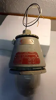

**VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar**

Pre-Owned

$34.99

+$14.45 shipping



Item description from the seller:
Transform your space with this vintage Appleton Electric A-51 Vented Explosion-Proof Industrial
Light Fixture - a perfect addition to your man cave, industrial garage, or home bar decor! Crafted
by the reputable Appleton Electric Company, this fixture boasts a unique blend of industrial charm
and safety features. The vented design ensures both functionality and a touch of nostalgia, making
it an ideal choice for enthusiasts seeking authentic vintage decor. Key Features: Manufacturer &
Model: Appleton Electric Company, A-51 Series Vented. Material: Durable metal body, likely aluminum,
for corrosion resistance. Safety Certification: UL and CSA certified, meeting safety standards for
hazardous locations. Voltage & Lamp Support: Supports up to 300 volts, compatible with various lamp
types (up to 200 watts). Mounting Instructions: Clearly marked "MOUNT VERTICAL" for correct
installation. Condition: Displays signs of wear and age; the ribbed glass enclosure is intact.
Please note, there is a slight gap in the top seal, and it may not be completely watertight. Elevate
your space with industrial decor that tells a story. Whether it's for your man cave, garage, or home
bar, this Appleton A-51 Vented Light Fixture is a conversation starter. Picture the warm glow adding
character to your favorite hangout spot. Buy now and let the vintage industrial charm illuminate
your unique style

- [Listing link](https://www.ebay.com/itm/386723431936?itmmeta=01HSWCF86Z5RS0VFPPBGQGZD8Z&hash=item5a0a834600:g:9QwAAOSwpDlluDud&itmprp=enc%3AAQAJAAABEPHSNGyQoO8pN8WmNRMHCIlNDmpuUw3yIBE1EGfu6VylzD0sxM2rFFpzuAbB1qudD9ipViG8rb02Tf%2B5YuTSw59fy7hbFG1d049FkuglOBFTrLDp0q92EBU8lCS16CFpf3g6JhcqkGMCQ1WWJDGRmY4AnvJjS4gRH5Bqk5A8VsgwgfpNkJTH4Ub5%2B%2FzqWhNb%2FHTDzzkyVXRTBUdATEsjxil1kl9Z2rZQEzmrxpNqtrizQ7mPkTFbFDdpRRh%2FZUdV1au4ED0825l%2F659I2MOfl0GDVryUD%2F4g2G7%2BdUNlAuXKMcInUhRlGf5hEBpwm5%2BwJLYS85dcWRjtS0tspFkpg%2FCw74GGUSmpHgzCJRiLGWgE%7Ctkp%3ABk9SR9SDvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/9QwAAOSwpDlluDud/s-l225.webp)

- eBay item number: 386723431936
----------------------------------------------------------------------------------------------------

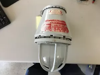

**APPLETON AP1550G EXPLOSION PROOF LIGHT FIXTURE**

New – Open box

$350.00

+$15.00 shipping



Item description from the seller:
APPLETON AP1550G EXPLOSION PROOF LIGHT FIXTURE WALL-12 M

- [Listing link](https://www.ebay.com/itm/163868905288?epid=4019404615&itmmeta=01HSWCF871V0RSTNFRSXPFW8SD&hash=item2627590f48:g:IgUAAOSwiT5dglZO&itmprp=enc%3AAQAJAAAA8El1VQJNUDO43ZcuC%2FJLSV3G4UsQ15iNvOuA5Arx3d%2BKMu43Q3vWwsCoYcLQC8CGnSgX1ZZThjU5l%2F%2BRoIAHxmfRtBxwBVvcibOhT8DlS9rsHBoDi8uKeQLrJcwErgn%2F%2BYvw2mj%2BRzmOeyOr3ONNtykWlp75eGFiiHx6y8mBDXCTsSWA9q2yoqVHOX5O1ZNCJSFQsgcBSsESy8L8Zi%2BqO01vfCynhN3AM8468e1FQ3sNVjjrex0Nww3%2BXZQqmqIo0EmMNLgojNhD7qtrq32E7yqW5JT2lM7YDVAGbP%2BXMRFd%2FoPYXnWOsK55pSpdEQL4FQ%3D%3D%7Ctkp%3ABk9SR9yDvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/IgUAAOSwiT5dglZO/s-l225.webp)

- eBay item number: 163868905288
----------------------------------------------------------------------------------------------------

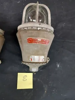

**VTG. 13" APPLETON ELECTRIC CO. EXPLOSION PROOF FACTORY LAMPS WITH CAGES $125 EA**

Pre-Owned

$117.00

+$20.00 shipping



Item description from the seller:
I have 2 fixtures, asking $125 each. These are vintage explosion proof light fixtures made by The
Appleton Electric Co. 300 V max. 150 watt max When ordering specify which fixture you would like
(see pictures). As of right now both are available

- [Listing link](https://www.ebay.com/itm/403584005053?itmmeta=01HSWCF8713PE3PC71GC025MSR&hash=item5df77b33bd:g:y7IAAOSwlThiS1pI&itmprp=enc%3AAQAJAAAA8N%2F2RmWMF%2BnHV2kcChl1NmMEvALpR%2FhyTkCDVKloyxPgZyGmZZ6VJfBQ8aGiOU5mdZAuI55vXAqmbFjCJ3VKqJxADbe4psQ1jcCNg315XFddf3pVNZbsa6FbhxV6V%2FJmhWrtC7%2FMKpGwtda6YCMTWt0%2FJpG4myeIu5Rq%2Bb2KrAIYXdmAXMwwY7pdKvdaiPPwIQVFAAp1vB6XcMI7uMW6cF0T1FaFL7KcKOoQKslljDNL9V7uPJFKEaUvms0BEQjMRdHlh5ews18CIy8gEAZb%2FGXewEqkp0Rbl281oAqhjbIKFvl%2F71FbdXMP7qmWrWdWeQ%3D%3D%7Ctkp%3ABk9SR96DvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/y7IAAOSwlThiS1pI/s-l225.webp)

- eBay item number: 403584005053
----------------------------------------------------------------------------------------------------

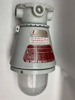

**Appleton,AAU-IN A-51 Series,Explosion Proof Light Fixture 100W**

New – Open box

$800.00

+$15.46 shipping



Item description from the seller:
New unused without original box NOS. Please see pictures for details and condition. You will receive
what’s in the pictures.  If we have multiples of the same item, the pictures may differ. Please
review the pictures to make sure the part number(s) match the item you are looking to replace. If
you notice that the part number in the listing, is different than what’s pictured, please contact us
so that we can fix it. Shipping: We offer USPS, FedEx, and freight shipping options.  OVERNIGHT
SHIPMENTS MUST BE PAID FOR BY 2PM EST for them to go same day. We ship to the address that is listed
on your eBay account, if the item is being shipped to a different address, please contact us
immediately so that we can get that shipped to the correct address. We ship Monday-Friday. All
weekend sales will be shipped on Monday. Returns: We have a 30 day hassle free return policy. All
return requests must be initiated within 30 days of date of receipt. Transactions outside of 30 Days
are not eligible for returns

- [Listing link](https://www.ebay.com/itm/325830974169?itmmeta=01HSWCF871V1J2D0Z0N4ED8FA8&hash=item4bdd0a1ad9:g:fKAAAOSw7ZdlFwO1&itmprp=enc%3AAQAJAAABEDV96hi3YCnkNHpRvhZtLQvYxhYwHDqrQerA3TIteG6o7%2BGes061QkMT6Qjvv6MrLfNDNnk8DcLzN76fWlp%2FlXloUYBlaU5i360cjeqdYP0Obq8crg6hRQxPag8%2BuvZLqT1QmPcunfSoFyYLLSjxHl1jCKJWeIFF4G8AweMkByZGBH3JDJNQ%2FhlQYpkkHmcPdU20Ca5W4vW2mlx5aG0gAca%2Fv52SgxzZnEWYTCqdOb9PoETbir5UHY8LPHZ5KNIOiGrxQH2yQM8gh5g0JJxi2uwRBza%2FIAOJ0zye18uzbv2oL%2FGYB%2Br90dA3oWJJtQD0NCPnauwQSKRwV5n6O%2BbIQPeW7%2Fs2ZNuqHY2qjnVXAHA0%7Ctkp%3ABk9SR96DvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/fKAAAOSw7ZdlFwO1/s-l225.webp)

- eBay item number: 325830974169
----------------------------------------------------------------------------------------------------

In [14]:
query_number = 0
search_type_code = 1  # base results = 0, image results = 1
print_search_results(all_results, search_tasks, query_number, search_type_code)

Search for `Vintage Appleton explosion-proof light fixture high-quality industrial decor` returned 87 results

Top results based on **eBay's search engine**:


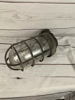

**Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light **

Pre-Owned

$5.50

+$9.62 shipping

Bid Status: 4 bids ·  - 1d 18h left



Item description from the seller:
I have a vintage Appleton form 200 shatter proof industrial light.  It's in working order has a nice
petina on it

- [Listing link](https://www.ebay.com/itm/315238138464?itmmeta=01HSWCHF0CJP4K6YA1KRST4S6D&hash=item4965a84260:g:UIgAAOSw7etl-13U&itmprp=enc%3AAQAJAAABADrAwVvpfGvAB0hvnjj%2B%2Brh3zEuFZ%2B2DqG3XRxkG52INlcUPDGNrekbwNyfs120mlGR%2FVJZyrFBZR8hhgHoHbEae9USe15m7OUMk6gUyApnvBPWpP3bj7FlmdwIE5FWrs%2B0WqIQljixEUazfLyqhbFq3dqeCtDVW2gIJZ0DiPv8TCRgnakHeGyUkptNZUCobKxzfT8wKbWu0WwTc2UVXMonwSpNb%2BKKIR5puTKqwXN9TLY5lwXCiuCDaXTRPsotIlbASTlLPPsBAyKQhw%2FVmaGfjcwaLHsE4imjshpL%2BCkojMGfcLacXAi%2FkCuxrfOxPQubM0RP2Yx7KtlTrp9bc%2B1I%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/UIgAAOSw7etl-13U/s-l300.webp)

- eBay item number: 315238138464
----------------------------------------------------------------------------------------------------

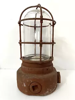

**Vtg Red Appleton Form 100-200 Explosion Proof Cage Light Fixture Steampunk**

Pre-Owned

$45.00

+$16.35 shipping



Item description from the seller:
You are purchasing a vintage Appleton Electric industrial cage light fixture.  It has a cool rust
red color.  There is surface wear throughout, see all photos. Please note it is untested and I am
not sure if the fixture is in working order or not.  The base is marked "Appleton Electric Co.
VXHA Unlit Form 100-200."   The porcelain light bulb socket is marked "Appleton Electric Company" &
"660 W - 250 V 550 W - 600 V."  The cage bulb guard is marked "Appleton."  When assembled the
fixture measures approximately 10 1/4" tall x 5" diameter base.  It measures 7lbs 14.5oz unpacked.
 It has such a great steampunk nautical look. I have multiple of these exact light fixtures.
 Message me if more than one is needed. Please contact me prior to purchasing with any questions.
SHIPPING: Domestically, I am offering FedEx Ground, UPS Ground, USPS Insured Priority Shipping &
USPS Ground Advantage

- [Listing link](https://www.ebay.com/itm/266728267524?itmmeta=01HSWCHF0CX33D0RZSVDMD9XZJ&hash=item3e1a3e5f04:g:aOkAAOSwNpdl-cpi&itmprp=enc%3AAQAJAAABAPHkk7EfiVEStsmqERNnKL2vcfWlZOGAN06W0nZ7ycPosbiBTQZODMoVbx%2FVGa%2F6Z4dS3dYgWJUuFuXUIrDfrlu7qa22%2FckKE%2B6CSrD1nsxdy%2FQzY41kgbOmlsCOM51pnH8ShJC3ttrWDYyltLMcrBFsVg4noxsxnXJhaL7Q%2B5taZ2y6m3ldp%2Fsqg1dbGGdx238O6TEXJUfk09Epes3IsSKT9f735ctiOXi%2BTiq2jbnY2SxmaC6pQ0zmX7KMTf6mWJp1DNA1SXhp0kiYvkRq1rGA1UQCbjsHTrTSyTSdSk3oD3mcJG%2BxV6X1zA%2FHX%2F%2B%2FQVhKsFEJUf3XOz74TTcjO9c%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/aOkAAOSwNpdl-cpi/s-l300.webp)

- eBay item number: 266728267524
----------------------------------------------------------------------------------------------------

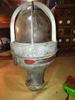

**Large vintage antique appleton Vented Explosion Proof Lighting Fixture steampunk**

Pre-Owned

$85.00

+$48.65 shipping

Bid Status: 0 bids ·  - 17h 30m left



Item description from the seller:
This large vintage antique Appleton lighting fixture is perfect for adding a touch of steampunk
style to any industrial lighting setup. Its vented design ensures safe operation in any facility,
making it an ideal choice for those in need of high-quality lighting fixtures for their business or
industrial space. With a brand name like Appleton, you can trust that this fixture is built to last
and will provide reliable lighting for years to come. Its unique vintage look is sure to draw
attention and add a touch of character to any space. Measures about 15 inches in lengt

- [Listing link](https://www.ebay.com/itm/166658150502?itmmeta=01HSWCHF0CV1QEMX4C76PN0TQ9&hash=item26cd999066:g:Y8IAAOSwgEpl1RBA&itmprp=enc%3AAQAJAAABACQZQUOAb6sz64MGbIaDTUKOl%2BTDGZnauNYIElGVvpiOlx%2FybjjaAVp1T3QaPgkD1RSKvqxEDHN1GI%2FaOfk7pSvh%2Fe%2Bae0olzGHezgP9v9WF%2FFTswM9%2Fll8Ks4nD%2FjhImGtD1LjGvHsUpZ%2FU4GQ79eNRE1y4UTJ1VRNWGXvN0B1PfS0WBuzMh1yrra0iCC8%2Bk7ZDrRR%2BNf4dqSXtA51WTnI2gIwTYew8EEEx8tPjeRnvzsH%2BAZB0wE%2B9tAcky7NpdkYHLxylZ4eA%2B3A0NIyyB1udVWegf%2FBBNkzqW1kbqraaeMMiL5h5wdoRqeQ2a0CpPZwgbS6H2nOC8mgAHvBklCY%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/Y8IAAOSwgEpl1RBA/s-l300.webp)

- eBay item number: 166658150502
----------------------------------------------------------------------------------------------------

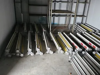

**Explosion Proof Light Fixture**

Pre-Owned

$250.00

+$94.97 shipping



Item description from the seller:
For sale are Rig-A-Lite explosion proof light fixtures is a great addition for any industrial
setting. Bulb Type: Fluorescen

- [Listing link](https://www.ebay.com/itm/364755388326?itmmeta=01HSWCHF0CBZC8ZG4QC0VEGHQX&hash=item54ed1d87a6:g:ufIAAOSwts1l02DD&itmprp=enc%3AAQAJAAABILDlK04Y7letRQZDt0ulZm7YYoNFpFgdMKCuYjGimdkrPy1N6X%2FP%2FRdenHJ9PUeso94KcK9%2F%2B%2Fu0AgIufsLqvvuf7G6vOyK2b2xK%2FjfMPkwZjFcxlywGgUHcTr1UhBDAYACUUKEw5utEVycEeEHm4Dr%2F8mEXua9tgmnjzdOt%2B0nOrHlZn0C1dsbcPAzuiYaOh1CjhjGrFtSOqtXuFQMH74lrPxldpPtHsWpMbFQpPGDLcEWa7RE8FQojY8bzPbmpqgf9XV1DotB043IzRvfZ1CpJd1VjRgHVCyQBhCCrbDW2FbNckJLucEq7kvAEWmvuvHB7TdxmQZOnWSk5osLJeR%2BjUkqFi%2FNi8gGzH5mqKrusw7ZVwFzVbVjyn7GQ7EYuGQ%3D%3D%7Ctkp%3ABk9SR6LwxYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/ufIAAOSwts1l02DD/s-l300.webp)

- eBay item number: 364755388326
----------------------------------------------------------------------------------------------------

In [17]:
query_number = 2
search_type_code = 0  # base results = 0, image results = 1
print_search_results(all_results, search_tasks, query_number, search_type_code)

In [51]:
# def search_listings(query: str):
#     """Run one eBay search query and return the top 10 results"""
#     search_results = eBayWebSearch(query)
#     output_string = ""
#     for res in search_results[:9]:
#         output_string += str(res)
#     return output_string

ai = Assistant(
    instructions="You are a helpful research assistant, skilled at drafting engaging reports that are well structured and nicely formatted.",
    # tools=[search_listings],
)
thread = Thread(
)
thread.add(
    f"Please analyze the ITEM DESCRIPTION and SEARCH RESULTS and use them to write a market research-style report. \
    Include in your report details on the top 5 SEARCH RESULTS that most closely resemble the DESCRIPTION. \
    Note that the SEARCH RESULTS contain a mix of text and image based searches. You can select from ANY of them to find the best matches.\n\nITEM DESCRIPTION: {initial_inspection}\n\nSEARCH RESULTS: {combined_search_results}",
)
run = thread.run(ai)
pprint_run(run)

╭─ Assistant ──────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                  │
│  ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│  ┃     Market Research Report: Vintage Appleton Explosion-Proof Industrial Light Fixtures     ┃  │
│  ┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛  │
│                                                                                                  │
│                                                                                                  │
│                                        Executive Summary                                         │
│                                                                                                  │
│  This report provides an analysis of vintage Appleton explosion-proof industrial light fixtures  │
│  available on eBay. The items are targeted at collectors, industrial businesses, and             │
│  individuals seeking distinctive home decor. The unique value proposition of these products      │
│  lies in their historical significance, robust construction, and the rising trend of             │
│  industrial-style home decor.                                                                    │
│                                                                                                  │
│                                                                                                  │
│                                Top 5 Comparable Listings on eBay                                 │
│                                                                                                  │
│   1 Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light               │
│      • Price: Current bid $5.50 + $9.62 shipping                                                 │
│      • Condition: Pre-Owned                                                                      │
│      • Description: The light is an Appleton form 200 shatterproof industrial light in working   │
│        order with a patina, indicative of its vintage nature.                                    │
│      • Listing Link: ]8;id=99996;https://www.ebay.com/itm/315238138464\eBay Listing]8;;\                                                                │
│   2 APPLETON ELECTRIC EXPLOSION PROOF FLUORESCENT Industrial 2-Bulb LIGHT FIXTURE                │
│      • Price: $159.99 + $39.95 shipping                                                          │
│      • Condition: Parts Only                                                                     │
│      • Description: Measuring approximately 23” long, these lights use 16.5” bulbs encased in    │
│        Pyrex glass, reinforcing the explosion-proof design. They are sold as found and untested  │
│        with a quantity of 6 available at the time of listing.                                    │
│      • Listing Link: ]8;id=894777;https://www.ebay.com/itm/145405189978\eBay Listing]8;;\                                                                │
│   3 VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar              │
│      • Price: $34.99 + $14.45 shipping                                                           │
│      • Condition: Pre-Owned                                                                      │
│      • Description: These lights combine an industrial aesthetic with functionality, offering    │
│        corrosion-resistant aluminum construction and compatibility with various lamp types.      │
│        Detailed mounting instructions come with the product.                                     │
│      • Listing Link: ]8;id=16369;https://www.ebay.com/itm/386723431936\eBay Listing]8;;\                                                  

In [52]:
query_eval0 = thread.get_messages()
query_eval_message0 = format_message(query_eval0[-1])
Markdown(query_eval_message0)

# Market Research Report: Vintage Appleton Explosion-Proof Industrial Light Fixtures

## Executive Summary

This report provides an analysis of vintage Appleton explosion-proof industrial light fixtures available on eBay. The items are targeted at collectors, industrial businesses, and individuals seeking distinctive home decor. The unique value proposition of these products lies in their historical significance, robust construction, and the rising trend of industrial-style home decor.

## Top 5 Comparable Listings on eBay

1. **Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light**
   - **Price:** Current bid $5.50 + $9.62 shipping
   - **Condition:** Pre-Owned
   - **Description:** The light is an Appleton form 200 shatterproof industrial light in working order with a patina, indicative of its vintage nature.
   - **Listing Link:** [eBay Listing](https://www.ebay.com/itm/315238138464)

2. **APPLETON ELECTRIC EXPLOSION PROOF FLUORESCENT Industrial 2-Bulb LIGHT FIXTURE**
   - **Price:** $159.99 + $39.95 shipping
   - **Condition:** Parts Only
   - **Description:** Measuring approximately 23” long, these lights use 16.5” bulbs encased in Pyrex glass, reinforcing the explosion-proof design. They are sold as found and untested with a quantity of 6 available at the time of listing.
   - **Listing Link:** [eBay Listing](https://www.ebay.com/itm/145405189978)

3. **VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar**
   - **Price:** $34.99 + $14.45 shipping
   - **Condition:** Pre-Owned
   - **Description:** These lights combine an industrial aesthetic with functionality, offering corrosion-resistant aluminum construction and compatibility with various lamp types. Detailed mounting instructions come with the product.
   - **Listing Link:** [eBay Listing](https://www.ebay.com/itm/386723431936)

4. **Vtg Red Appleton Form 100-200 Explosion Proof Cage Light Fixture Steampunk**
   - **Price:** $45.00 + $16.35 shipping
   - **Condition:** Pre-Owned
   - **Description:** Featuring a striking rust-red color and classic steampunk nautical look, these lights carry signs of wear but have authentic vintage appeal. They are untested, and multiple units are available.
   - **Listing Link:** [eBay Listing](https://www.ebay.com/itm/266728267524)

5. **APPLETON AP1550G EXPLOSION PROOF LIGHT FIXTURE**
   - **Price:** $350.00 + $15.00 shipping
   - **Condition:** New – Open box
   - **Description:** These fixtures are wall-mounted and come with the promise of the Appleton brand's durability despite being an open-box item.
   - **Listing Link:** [eBay Listing](https://www.ebay.com/itm/163868905288)

## Market Trend Analysis

The market for vintage industrial fixtures has been growing, with an increased interest in integrating these items within urban and rustic home decor settings. As consumers become more eco-conscious, the desire to repurpose old industrial items contributes to this trend.

## Prices and Conditions

The prices range substantially from $5.50 to $800, reflecting the varying conditions of the fixtures from pre-owned and untested to new open box items. 

## Recommendations

For consumers:
- For a working condition light with vintage aesthetics, the Vintage Explosion Proof Appleton Form 200 Caged Light and VTG Appleton A-51 Vented Explosion-Proof Industrial Light are recommended.

For sellers:
- Ensure products are clean and accurately described to build trust with potential buyers.
- Highlight any historical or unique features of the light fixtures to appeal to collectors and enthusiasts.

## Concluding Thoughts

Vintage Appleton explosion-proof industrial light fixtures serve a niche but growing market of industrial decor enthusiasts. While the condition and pricing vary, these items hold significant potential for those looking to add an authentic industrial flair to their spaces. Retailers can capitalize on this interest by offering well-maintained and documented vintage fixtures.

In [78]:
target_image = "https://i.ebayimg.com/thumbs/images/g/9QwAAOSwpDlluDud/s-l300.jpg"
display(Image(url=target_image))

In [79]:
import textwrap
import marvin
from pydantic import BaseModel, Field


class eBayListingItem(BaseModel):
    """An item for sale on eBay"""
    title: str = Field(description="A concise tag-line style title for the item.")
    item_specifications: str = Field(description="A detailed inspection of the item in the style of product details or technical specs.")
    seo_style_ebay_listing: str = Field(description="A SEO-focused compelling description of the item. It should be engaging to read, helping users imagine how the item could positively impact their life.")
    
    def __str__(self):
        wrapped_description = textwrap.fill(self.seo_style_ebay_listing, width=100)
        return f"## {self.title}\n\n**Item Description:**\n\n{wrapped_description}"
        

img = marvin.beta.Image(
    target_image
)
result = marvin.beta.cast(
    data=img, 
    target=eBayListingItem,
    instructions="You are a wold class eBay seller, an expert at vividly describing items and crafting irresistable listing descriptions.",
)

## Authentic Vintage Industrial Pendant Light with Patina

**Item Description:**

Illuminate your space with a touch of history - this authentic vintage industrial pendant light is a
true treasure. Its tapered design, featuring a metallic top and a clear, ribbed glass shade, exudes
an antique charm that's hard to find. The light's patina and signs of wear tell a story of its past,
making it not just a lighting fixture but a conversation piece. Perfect for those who appreciate the
beauty of aged objects, this pendant light is ready to be wired and bring a warm, inviting glow to
your home or office. Don't miss the chance to own a piece of history!

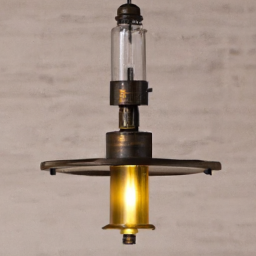

Type: Pendant Light; Style: Vintage/Industrial; Material: Metal, Glass; Shade: Clear, Ribbed;
Condition: Used, Signs of Wear and Patina; Wiring: Black, Ready for Installation; Label:
Manufacturer Information (Not Legible)

In [80]:
image_test = llm.prompt_image_gen(
    prompt=str(result.seo_style_ebay_listing),
    model="dall-e-2",
    size_category="small",
    style="natural",
)
image_path = image_test.get('file_path')
display(Markdown(str(result)))
display(Image(filename=image_path))
wrapped_specs = textwrap.fill(result.item_specifications, width=100)
display(Markdown(f"{wrapped_specs}"))

In [25]:
# %%time
search_results = eBayWebSearch(search_tasks[0])
nest_asyncio.apply()
asyncio.run(process_ebay_images_with_async(search_results))
search_results = deduplicate_products(search_results)
df = pd.DataFrame([r.to_data_dict for r in search_results])
print(f"Found {len(search_results)} search results")
df.head(2)

Found 95 search results
CPU times: total: 203 ms
Wall time: 391 ms


,id,title,price,shipping,location,condition,text,listing_url,image_url,image_base64,image_uri,hash_id
0,315238138464,Vintage Explosion Proof Appleton Form 200 Cage...,$5.50,+$9.62 shipping,None,Pre-Owned,eBay\nI have a vintage Appleton form 200 shatt...,https://www.ebay.com/itm/315238138464?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/UIgAAOSw...,UklGRqoSAABXRUJQVlA4IJ4SAAAwZQCdASqpAOEAPm0wlE...,data\multimodal\Vintage_Explosion_Proof_Applet...,b8e6c30462593ad3572ae259ca679a9c
1,145405189978,APPLETON ELECTRIC EXPLOSION PROOF FLUORESCENT ...,$159.99,+$39.95 shipping,None,Parts Only,eBay\nVintage APPLETON ELECTRIC EXPLOSION PROO...,https://www.ebay.com/itm/145405189978?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/F8AAAOSw...,UklGRoAtAABXRUJQVlA4IHQtAAAQgACdASqpAOEAPm0okE...,data\multimodal\APPLETON_ELECTRIC_EXPLOSION_PR...,b94fcaaac3a2c696c0d868056149de29



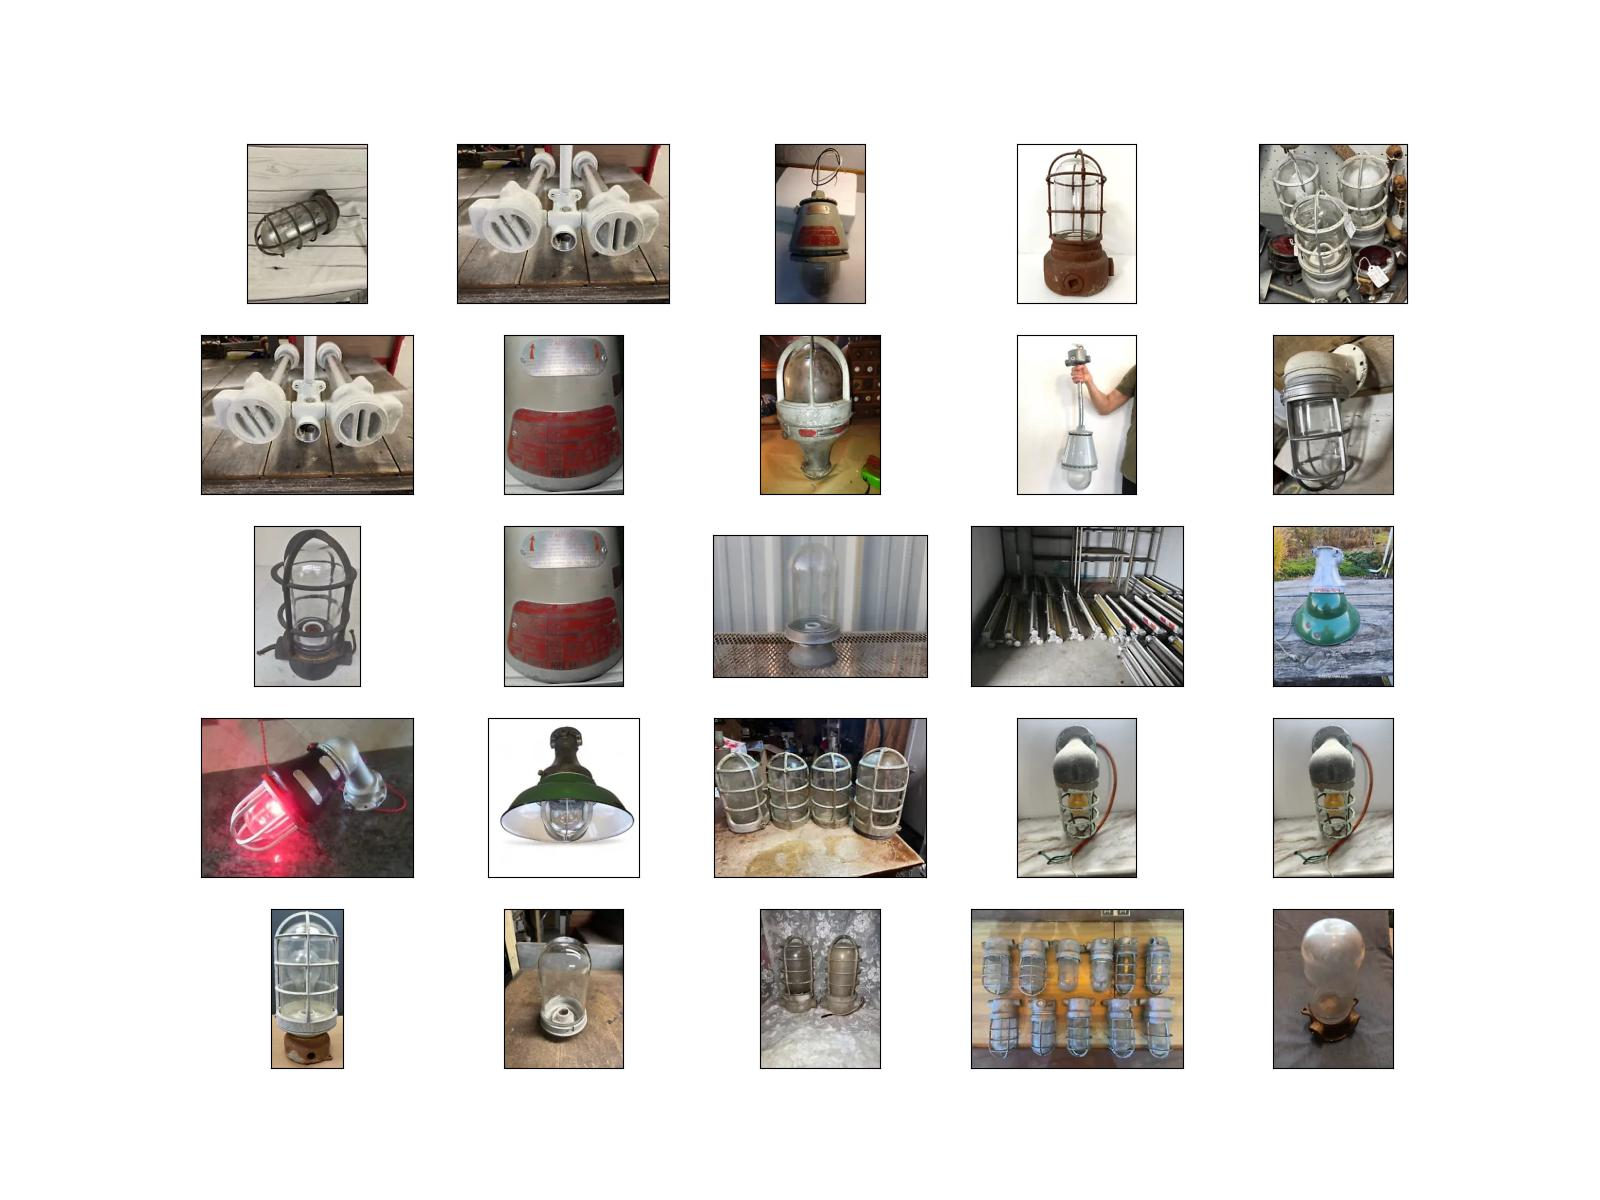

In [26]:
image_paths = [str(r.full_path) for r in search_results]
base64_image = plot_images(image_paths, './data/output_plot.jpg')
HTML(f'<img src="data:image/jpeg;base64,{base64_image}" />')

In [31]:
def search_image_vectors(image_path: str, df: pd.DataFrame):
    df["similarity_score"] = "0.0"
    db = lancedb.connect("./.lancedb")
    table = db.create_table("ebay", schema=eBayItems, mode='overwrite')
    table.add(df)
    # To to open the input as an image
    try:
        query = PILImage.open(image_path)
    # Fallback to text search
    except:
        query = str(image_path)
    rs = table.search(query) \
        .limit(10) \
        .to_pandas()
    rs["similarity_score"] = 1 - rs["_distance"]
    rs["similarity_score"] = rs["similarity_score"].astype('string')
    list_of_dicts = rs.to_dict(orient='records')
    return [eBayItems(**item) for item in list_of_dicts]

In [32]:
rs = search_image_vectors("test_image.jpg", df=df)

100%|██████████| 31/31 [00:00<00:00, 32.39it/s]


In [38]:
Markdown(str(rs[0]))

**Appleton Portable Hazardous Locations Explosion Proof Hanging Light 50’ Cord**

Pre-Owned

$199.00

+$33.48 shipping



Item description from the seller:
Lightbulb not included. Light will be shipped with NO bulb. Long 50 foot cord. Used but in good
working condition. Please see all pictures for condition. This is a USED item. Appleton Industrial
Portable Hazardous Locations Explosion Proof Hanging Light 50â€™ Cord. Approved for hazardous
locations. Waterproof, Impact and heat resistant globe. Provides safe, bright portable task specific
lighting in hazardous industrial locations. Can be used in restricted spaces such as oil refineries,
tank inspections, fuel storage centers, and other classified hazardous areas where ordinary lamps
are not permitted. Item has been weighed and measured in the box that it will be shipped in so that
shipping is exact to your zip code

- [Listing link](https://www.ebay.com/itm/155086595503?itmmeta=01HSWCF871EX9CDNF47WXJBEM0&hash=item241be1a5af:g:0HAAAOSwlG5i2ctH&itmprp=enc%3AAQAJAAAA8EupzbY297xMJUvpq3vkOW8nlvpEkpT%2BmHeP9jUw5ReGOCWjZcRqjJLTrloNkJYubZ6eiXhNqm5Ch0VttzLVv4dBzPQPnKAh9rpmeyYplCgqYyg2OKdU7X2XwvTL76lVAQ5sc8PbPvL70RNNvxy2v7sqYRL%2BMjNYHjbxo%2Bzkp8Bd5dcK83gVw1Aw6kCOqLQYA1b6OiQvQvPdwpyR2lMZKDRqOiUaA3e4iUIJCghJRN9oXr3Un2BdaKUCK7o2jE%2BdBCKb%2B07mbvFgN3Gv9KoOQZ4EwinfpO6r9midMyrCtbqJdAf9njN4fX6mMpCCHTLbsw%3D%3D%7Ctkp%3ABk9SR9yDvYzPYw)

- [Image link](https://i.ebayimg.com/thumbs/images/g/0HAAAOSwlG5i2ctH/s-l225.webp)

- eBay item number: 155086595503
----------------------------------------------------------------------------------------------------

* Using text to search images

100%|██████████| 31/31 [00:00<00:00, 35.96it/s]


**Appleton Portable Hazardous Locations Explosion Proof Hanging Light 50’ Cord**

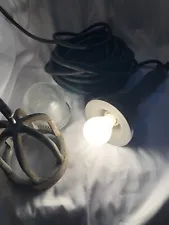

In [36]:
text_search = "lightbulb"
rs = search_image_vectors(text_search, df=df)
display(Markdown(f"**{rs[0].title}**"))
rs[0].image

100%|██████████| 31/31 [00:00<00:00, 35.92it/s]


**Vtg Crouse Hinds Industrial Explosion Proof Shop Wall Or Ceiling Light Fixture**

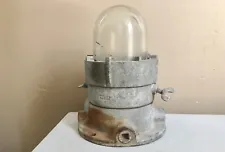

In [40]:
text_search = "Vintage Appleton Explosion-Proof Industrial Light Fixture"
rs = search_image_vectors(text_search, df=df)
display(Markdown(f"**{rs[0].title}**"))
rs[0].image

In [279]:
import jinja2
import pdfkit


async def convert_html_to_pdf(
    html_string: str,
    image_url: str,
    template_folder: str = "./static",
    base_html_file: str = "base.html",
    output_file: str = "generate_pdf.pdf",
    output_folder: str = "./data",
) -> str:

    if output_folder.endswith("/"):
        raise ValueError("Wrong output folder name, should not end with '/'")
    else:
        pdf_file_name = f"{output_folder}/{output_file}"

    try:
        template_loader = jinja2.FileSystemLoader(template_folder)
        template_env = jinja2.Environment(loader=template_loader)

        basic_template = template_env.get_template(base_html_file)

        output_html_code = basic_template.render()
        # print(output_html_code)

        # render content, this if for once we have AI generated response
        output_html_code = basic_template.render(
            ai_generated_content=html_string,
            image_url=image_url,
        )

        options = {
            'page-size': 'A4',
            'margin-top': '0.75in',
            'margin-bottom': '0.75in',
            'margin-right': '0.55in',
            'margin-left': '0.55in',
            'encoding': "UTF-8",
            'footer-right': '[page] of [topage]',
            'footer-font-size': "9",
            'custom-header': [
                ('Accept-Encoding', 'gzip')
            ],
            'enable-local-file-access': False,
            'no-outline': None,
            'enable-local-file-access': False,
            'no-outline': None
        }

        pdfkit.from_string(
            input=output_html_code,
            output_path=pdf_file_name,
            options=options
        )

    except Exception as e:
        print(e)
        return ""

    return pdf_file_name

In [280]:
template_str = '''
<table class="poll-table">
  <thead>
    <tr>
      {% for c in columns %}
      <th>{{ c.title() }}</th>
      {% endfor %}
    </tr>
  </thead>
  <tbody>
     {% for row in rows %}
     <tr>
     {% for k, v in row.items() %}
      <td>
        {% if k == 'title' %}
        <!-- Link the title to the item's URL -->
        <a href="{{ row['listing_url'] }}" style="color: #000; text-decoration: none;">{{ v }}</a>
        {% elif k == 'listing_url' %}
        <!-- Skip rendering listing_url as it's already linked with title -->
        {% else %}
        {{ v }}
        {% endif %}
     </td>
     {% endfor %}
     </tr>
     {% endfor %}
  </tbody>
</table>

<style>
.poll-table {
  max-width: 960px; 
  width: 100%;
  border-collapse: collapse;
  font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif;
  margin: 0 auto;
  box-shadow: 0 2px 3px rgba(0,0,0,0.1);
}

.poll-table th,
.poll-table td {
  page-break-inside: avoid; 
  border: 1px solid #ddd;
  padding: 10px 15px;
  text-align: left;
  font-size: 14px;
  border-left: none;
  border-right: none;
  overflow: hidden;
  text-overflow: ellipsis;
}

.poll-table th {
  background-color: #000;
  color: #fff;
  font-weight: bold;
  font-size: 24px;
  overflow: hidden;
}

.poll-table tr:nth-child(even) {
  background-color: #f9f9f9;
}

.poll-table tr:hover {
  background-color: #f1f1f1;
}

.poll-table tbody td {
  border-bottom: 1px solid #ddd;
}

.poll-table  {
  border: 1px solid #000;
}

.poll-table td:first-child,
.poll-table th:first-child {
  border-left: 1px solid #ddd;
}

.poll-table td:last-child,
.poll-table th:last-child {
  border-right: 1px solid #ddd;
}
</style>
'''

In [240]:
# df["price"] = df['price'].str.replace('$', '').str.replace(',', '')
# df["price"] = df["price"].astype(float)
df.head(1)

,id,title,price,shipping,location,condition,text,listing_url,image_url,image_base64,image_uri,hash_id,similarity_score,item_price,item,title_link
0,315238138464,Vintage Explosion Proof Appleton Form 200 Cage...,5.5,+$9.62 shipping,None,Pre-Owned,eBay\nI have a vintage Appleton form 200 shatt...,https://www.ebay.com/itm/315238138464?itmmeta=...,https://i.ebayimg.com/thumbs/images/g/UIgAAOSw...,UklGRqoSAABXRUJQVlA4IJ4SAAAwZQCdASqpAOEAPm0wlE...,data\multimodal\Vintage_Explosion_Proof_Applet...,b8e6c30462593ad3572ae259ca679a9c,0.0,5.5,5.5,"<a href=""https://www.ebay.com/itm/315238138464..."


In [257]:
def create_hyperlink(title: str, url: str) -> str:
    """
    Creates an HTML hyperlink with custom styling.

    Args:
        title (str): The display text for the hyperlink.
        url (str): The URL the hyperlink points to.

    Returns:
        str: An HTML string containing the hyperlink with custom styling.
    """
    return f'<a href="{url}" style="color: #2D3748; text-decoration: none;">{title}</a>'

# Apply the function to create a new column with HTML hyperlinks
df['Title'] = df.apply(lambda row: create_hyperlink(row['title'], row['listing_url']), axis=1)

In [282]:
from jinja2 import Template

template = Template(template_str)

html = template.render(
    rows=df[['Title', 'price', 'shipping', 'condition']].head(10).to_dict(orient='records'),
    columns=df[['Title', 'price', 'shipping', 'condition']].columns.to_list()
)

HTML(html)

Title,Price,Shipping,Condition
"<a href=""https://www.ebay.com/itm/315238138464?itmmeta=01HSWCF86Z58WBJQAEBBF8KTDG&hash=item4965a84260:g:UIgAAOSw7etl-13U&itmprp=enc%3AAQAJAAABEKkfAJ45%2FiI530Tfk%2F7wPNz83nY64IvoiQpzOInyo%2F0eCVHSWICArUvMOYQlFnlqA3oXzqiz1ado39NON9JaCALf93kdk%2B1C4qXmG3wk%2BJVEYRBrFn9Q8iaK9AduwGwHbhBHN9R%2FcqbX5Ri2EeScz79AmBAncNEhnD5lqQIY8sObX5CUtcto6vUeNYJCZ6zaLtPBf5TpT2Ms8%2FgPH7uVLxkQ6PYlm7IIjkHZ3cHtrXcz4AnAle69xth2XP7rRMXtfklzErne%2BsV7s9etIN2XhelWXKuC6MwZa3KhOBrYjFj9MXA10FHXym9xr93yvyGq4wvvs7OLtuS9pxDBz%2FGBvXUzOva0FuKv%2FbnpImnZnhUl%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">Vintage Explosion Proof Appleton Form 200 Caged Light Vintage Industrial Light",5.5,+$9.62 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/145405189978?itmmeta=01HSWCF86Z5SYZP5T0FM18YJZ9&hash=item21dad31f5a:g:F8AAAOSw-ABkh03R&itmprp=enc%3AAQAJAAAA8CAsUXQ17a3RrBCALlL7xMKmFYfsv0INttoWKj3OKoGgDBY3nQjikFC5TnZE0P7DfR4F4uhSmxMugPnnAu9p%2BgNwMxkRcgWVdsz9ry6aCfmLvArTYmQk5%2Bx1jra%2BhPQKA7KMDskmtfOjAV1JfN%2BdoX0kBO6uPpdR8%2BZBkkMDiPzJpWvVVFtxYUfAAVCRgI10Jct4QPKtHxw1pr4G590TvJhR7%2FluWwOckxbcE1zCzdsUTdo5qfDJn7M5K3XvN7Or4xX3gCvZ4%2FbBSaXLXzaUxmsJMqk0Jx7vXU%2FkvFLAWr05x98pJ7JAcTn4LmxqW0LGWQ%3D%3D%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">APPLETON ELECTRIC EXPLOSION PROOF FLUORESCENT Industrial 2-Bulb LIGHT FIXTURE",159.99,+$39.95 shipping,Parts Only
"<a href=""https://www.ebay.com/itm/386723431936?itmmeta=01HSWCF86Z5RS0VFPPBGQGZD8Z&hash=item5a0a834600:g:9QwAAOSwpDlluDud&itmprp=enc%3AAQAJAAABEPHSNGyQoO8pN8WmNRMHCIlNDmpuUw3yIBE1EGfu6VylzD0sxM2rFFpzuAbB1qudD9ipViG8rb02Tf%2B5YuTSw59fy7hbFG1d049FkuglOBFTrLDp0q92EBU8lCS16CFpf3g6JhcqkGMCQ1WWJDGRmY4AnvJjS4gRH5Bqk5A8VsgwgfpNkJTH4Ub5%2B%2FzqWhNb%2FHTDzzkyVXRTBUdATEsjxil1kl9Z2rZQEzmrxpNqtrizQ7mPkTFbFDdpRRh%2FZUdV1au4ED0825l%2F659I2MOfl0GDVryUD%2F4g2G7%2BdUNlAuXKMcInUhRlGf5hEBpwm5%2BwJLYS85dcWRjtS0tspFkpg%2FCw74GGUSmpHgzCJRiLGWgE%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">VTG Appleton A-51 Vented Explosion-Proof Industrial Light - Man Cave Garage Bar",34.99,+$14.45 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/266728267524?itmmeta=01HSWCF86ZE9D87HYQ5TSFA8HY&hash=item3e1a3e5f04:g:aOkAAOSwNpdl-cpi&itmprp=enc%3AAQAJAAAA8PHkk7EfiVEStsmqERNnKL2vcfWlZOGAN06W0nZ7ycPosbiBTQZODMoVbx%2FVGa%2F6Zz5PhZfkGj3nSr2cT0%2BC6fHoNNzCS3n843kyg0npd5cpZpIXtjj2JOv43arMfbhFzj%2FhGlN9noIkuf8xGRDyt8bZ2BPADw9%2Fk7RrgWrpvCDhxrCWQPSGvnw6Nju8cdh1B8d9IoMWbL3P075HaDsWK5jxU9nmjnqyywCBfeTUaO4VuKbWGP9rl34h6w4a3tw2UKfV2XB9B%2BOEbA4uSp5S9wNtBQKsSEZ1NKTERBjbhxai6Avnle5Wg%2Fh6IZgLimgvUQ%3D%3D%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">Vtg Red Appleton Form 100-200 Explosion Proof Cage Light Fixture Steampunk",45.0,+$16.35 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/266737830306?itmmeta=01HSWCF86Z15V0CNTEY57N5RX7&hash=item3e1ad049a2:g:OFcAAOSwqCVmAgLT&itmprp=enc%3AAQAJAAABEC5z03LEcjxKRb6rxVN06h%2Bza%2BvfGh4epnwImrUECmbGKV%2BJsTteS2jwro5NM2ZPtDLw6y%2FSwD3fV9bUjX%2Fp%2FE52HlAzm3VBN25%2FoX12s6FPdRG1ovBOLWPTuHMBMivSTK4IQDHy%2BJC%2BKS%2FifzpZfD9HLOW0MOveFKvUAVpoysw4NLXFN4Axs6l5o%2Fsxn5MYm5A9yWgAigOxaCg1Frubdzsl0fQa4ZPUOcexyCaFCGly8AbvEmS0fQ5Hla7kpxbyCzxvdLAMEU1PQepJ6aheV9%2BKSc9tPdQHV%2BmRr6L%2FVHqm45ewYlnK4nUwSskSueo3DPC%2B4aACkF3tI5YAtBHZMqbu14n2kEYpUFSkxq7mB4As%7Ctkp%3ABk9SR9SDvYzPYw"" style=""color: #2D3748; text-decoration: none;"">New ListingThree (3) Appleton Electric Form 100 Explosion Proof Industrial Lights Caged",245.0,+$56.70 shipping,Pre-Owned
"<a href=""https://www.ebay.com/itm/296308287712?itmmeta=01HSWCF86ZNAJCTX8PZP6KJXY8&hash=item44fd59a8e0:g:m6cAAOSw~ZRl33G1&itmprp=enc%3AAQAJAAABEGCwhBRc4cX7485asBMcBh5lCGNDg4ounh3b5x59Tw%2FKa5HJEJXok9wABrh1kgTU46uf9aKmkwQiwQukMW%2BQbCgzHk8Y8kuOGhVEicHEqFpttXcPPQL7hxUzGAPAn3--iETzmmj8Rbpzk2bKX%2BYRExNHIiXlZ619YC7wtpI7fNLAQ1I3ALV1QfE7dEaVH3qg2cqqytgxxiHE4ysFQIuXqARtJvEpv68MSYClqEWx5uUUCC2VYeEJ635e6tSoh%2BWM6Jrl7Up0lEQqz%2FKBsahmaKPSMZunBxYxDz0VPTFbehlM2B76

In [295]:
import markdown
import nest_asyncio
nest_asyncio.apply()

text = initial_inspection + "\n\n\n\n" + avg_pricing_message_str + "\n\n" + query_eval_message0 + "\n\n" + results0 +  "\n\n" + results1 + "\n\n" + html

html_str = markdown.markdown(text, extensions=['pymdownx.magiclink'])

generated_pdf_file_name = asyncio.run(
    convert_html_to_pdf(
    html_string=html_str,
    image_url=target_image,
))